In [1]:
import pandas as pd
import numpy as np

import hts
from hts import HTSRegressor
import pmdarima as pm
from fbprophet import Prophet


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from hts.hierarchy import HierarchyTree

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# import the data files
data = pd.read_excel('./data.xlsx',sheet_name='Quadro', skiprows=11, usecols="A:D", header=None, index_col=0)

In [4]:
first_row = data.loc["Years",:]
data.columns=first_row
data.drop(data.index[[0]],inplace=True)

In [5]:
# lowercase the column names
data.columns = [col_name.lower() for col_name in data.columns]

In [6]:

# cleanup region name 
data["nutsiii"] = data["nutsiii"].apply(lambda x: x.replace(" ", "_"))

# map the full NUTSII names to abbreviations
nutsii_dict = {
    "Norte": "NT",
    "Centro": "CT",
    "Área Metropolitana de Lisboa": "LIS",
    "Alentejo": "ALT",
    "Algarve": "ALG",
    "Região Autónoma dos Açores": "AÇR",
    "Região Autónoma da Madeira": "MAD",
}

data["nutsii"] = data["nutsii"].map(nutsii_dict)

# create the bottom level id
data["nutsii_nutsiii"] = data.apply(lambda x: f"{x['nutsii']}_{x['nutsiii']}", axis=1)

data.head()

nutsii                      nutsiii nº of nights  \
0                                                                      
2009-12-31 00:00:00     NT                   Alto_Minho            0   
2009-12-31 00:00:00     NT                       Cávado      515.714   
2009-12-31 00:00:00     NT                          Ave      295.402   
2009-12-31 00:00:00     NT  Área_Metropolitana_do_Porto            0   
2009-12-31 00:00:00     NT                  Alto_Tâmega            0   

                                     nutsii_nutsiii  
0                                                    
2009-12-31 00:00:00                   NT_Alto_Minho  
2009-12-31 00:00:00                       NT_Cávado  
2009-12-31 00:00:00                          NT_Ave  
2009-12-31 00:00:00  NT_Área_Metropolitana_do_Porto  
2009-12-31 00:00:00                  NT_Alto_Tâmega

In [7]:
data.reset_index(inplace=True)
data.columns.values[0]="date"
data

date nutsii                      nutsiii nº of nights  \
0   2009-12-31     NT                   Alto_Minho            0   
1   2009-12-31     NT                       Cávado      515.714   
2   2009-12-31     NT                          Ave      295.402   
3   2009-12-31     NT  Área_Metropolitana_do_Porto            0   
4   2009-12-31     NT                  Alto_Tâmega            0   
..         ...    ...                          ...          ...   
403 2020-12-31    AÇR                Ilha_do_Faial        44.39   
404 2020-12-31    AÇR              Ilha_das_Flores       22.416   
405 2020-12-31    AÇR                Ilha_do_Corvo        1.166   
406 2020-12-31    MAD              Ilha_da_Madeira     2282.241   
407 2020-12-31    MAD          Ilha_de_Porto_Santo      159.295   

                     nutsii_nutsiii  
0                     NT_Alto_Minho  
1                         NT_Cávado  
2                            NT_Ave  
3    NT_Área_Metropolitana_do_Porto  
4                    NT_Alto_Tâmega  
..                              ...  
403               AÇR_Ilha_do_Faial  
404             AÇR_Ilha_das_Flores  
405               AÇR_Ilha_do_Corvo  
406             MAD_Ilha_da_Madeira  
407         MAD_Ilha_de_Porto_Santo  

[408 rows x 5 columns]

In [8]:
# inspect all the regions per nutsii
data.groupby("nutsii")["nutsiii"].apply(set).to_frame()

nutsiii
nutsii                                                   
ALG                                             {Algarve}
ALT     {Alentejo_Litoral, Alentejo_Central, Lezíria_d...
AÇR     {Ilha_do_Faial, Ilha_Terceira, Ilha_de_Santa_M...
CT      {Beiras_e_Serra_da_Estrela, Médio_Tejo, Oeste,...
LIS                        {Área_Metropolitana_de_Lisboa}
MAD                {Ilha_de_Porto_Santo, Ilha_da_Madeira}
NT      {Área_Metropolitana_do_Porto, Terras_de_Trás-o...

In [9]:
# create the bottom level data
data_bottom_level = data.pivot(index="date", columns="nutsii_nutsiii", values="nº of nights")

# create the middle level data
data_middle_level = data.groupby(["date", "nutsii"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="nutsii", values="nº of nights")

# create the total level data
data_total = data.groupby("date")["nº of nights"] \
             .sum() \
             .to_frame() \
             .rename(columns={"nº of nights": "total"})


In [10]:

# join the DataFrames
hierarchy_data = data_bottom_level.join(data_middle_level) \
                              .join(data_total)
hierarchy_data.index = pd.to_datetime(hierarchy_data.index)


print(f"Number of time series at the bottom level: {data_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {data_middle_level.shape[1]}")

hierarchy_data.head()

Number of time series at the bottom level: 34
Number of time series at the middle level: 7


ALG_Algarve ALT_Alentejo_Central ALT_Alentejo_Litoral  \
date                                                               
2009-12-31   12927.603              383.064              277.538   
2010-12-31    13247.45              403.992              307.195   
2011-12-31   13979.866              411.336              376.595   
2012-12-31   14326.774               389.28              370.033   
2013-12-31   14741.969                    0              349.377   

           ALT_Alto_Alentejo ALT_Baixo_Alentejo ALT_Lezíria_do_Tejo  \
date                                                                  
2009-12-31           175.475            172.589              95.649   
2010-12-31           183.086             179.06              99.225   
2011-12-31           189.742            167.212              98.767   
2012-12-31           150.747            142.039              90.046   
2013-12-31                 0            132.437              85.383   

           AÇR_Ilha_Graciosa AÇR_Ilha_Terceira AÇR_Ilha_das_Flores  \
date                                                                 
2009-12-31             9.512           141.563                   0   
2010-12-31            16.043           131.507              14.229   
2011-12-31            16.449           140.675                15.8   
2012-12-31            14.072           135.388              13.666   
2013-12-31            10.943           146.948              13.136   

           AÇR_Ilha_de_Santa_Maria  ... NT_Tâmega_e_Sousa  \
date                                ...                     
2009-12-31                  22.164  ...                 0   
2010-12-31                  23.933  ...                 0   
2011-12-31                  23.122  ...                 0   
2012-12-31                  21.098  ...                 0   
2013-12-31                  21.061  ...                 0   

           NT_Área_Metropolitana_do_Porto        ALG       ALT      AÇR  \
date                                                                      
2009-12-31                              0  12927.603  1104.315  253.101   
2010-12-31                              0  13247.450  1172.558  266.744   
2011-12-31                              0  13979.866  1243.652  271.891   
2012-12-31                              0  14326.774  1142.145  257.839   
2013-12-31                              0  14741.969   567.197  269.142   

                  CT        LIS       MAD        NT      total  
date                                                            
2009-12-31  1254.849      0.000   240.426  1026.364  16806.658  
2010-12-31  1254.948      0.000  4993.525   976.605   21911.83  
2011-12-31  1422.553      0.000  5565.286   966.599  23449.847  
2012-12-31  1367.118      0.000  5507.685   966.026  23567.587  
2013-12-31   688.869  10040.808   288.579   756.368  27352.932  

[5 rows x 42 columns]

In [11]:
#Creating the hierarchy
nutsii = data["nutsii"].unique()
nutsiii = data["nutsii_nutsiii"].unique()

total = {'total': list(nutsii)}
nutsii = {k: [v for v in nutsiii if v.startswith(k)] for k in nutsii}
hierarchy = {**total, **nutsii}

hierarchy

{'total': ['NT', 'CT', 'LIS', 'ALT', 'ALG', 'AÇR', 'MAD'],
 'NT': ['NT_Alto_Minho',
  'NT_Cávado',
  'NT_Ave',
  'NT_Área_Metropolitana_do_Porto',
  'NT_Alto_Tâmega',
  'NT_Tâmega_e_Sousa',
  'NT_Douro',
  'NT_Terras_de_Trás-os-Montes'],
 'CT': ['CT_Oeste',
  'CT_Região_de_Aveiro',
  'CT_Região_de_Coimbra',
  'CT_Região_de_Leiria',
  'CT_Viseu_Dão_Lafões',
  'CT_Beira_Baixa',
  'CT_Médio_Tejo',
  'CT_Beiras_e_Serra_da_Estrela'],
 'LIS': ['LIS_Área_Metropolitana_de_Lisboa'],
 'ALT': ['ALT_Alentejo_Litoral',
  'ALT_Baixo_Alentejo',
  'ALT_Lezíria_do_Tejo',
  'ALT_Alto_Alentejo',
  'ALT_Alentejo_Central'],
 'ALG': ['ALG_Algarve'],
 'AÇR': ['AÇR_Ilha_de_Santa_Maria',
  'AÇR_Ilha_de_São_Miguel',
  'AÇR_Ilha_Terceira',
  'AÇR_Ilha_Graciosa',
  'AÇR_Ilha_de_São_Jorge',
  'AÇR_Ilha_do_Pico',
  'AÇR_Ilha_do_Faial',
  'AÇR_Ilha_das_Flores',
  'AÇR_Ilha_do_Corvo'],
 'MAD': ['MAD_Ilha_da_Madeira', 'MAD_Ilha_de_Porto_Santo']}

In [12]:
Htree = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_data)
Htree

- total
   |- NT
   |  |- NT_Alto_Minho
   |  |- NT_Cávado
   |  |- NT_Ave
   |  |- NT_Área_Metropolitana_do_Porto
   |  |- NT_Alto_Tâmega
   |  |- NT_Tâmega_e_Sousa
   |  |- NT_Douro
   |  - NT_Terras_de_Trás-os-Montes
   |- CT
   |  |- CT_Oeste
   |  |- CT_Região_de_Aveiro
   |  |- CT_Região_de_Coimbra
   |  |- CT_Região_de_Leiria
   |  |- CT_Viseu_Dão_Lafões
   |  |- CT_Beira_Baixa
   |  |- CT_Médio_Tejo
   |  - CT_Beiras_e_Serra_da_Estrela
   |- LIS
   |  - LIS_Área_Metropolitana_de_Lisboa
   |- ALT
   |  |- ALT_Alentejo_Litoral
   |  |- ALT_Baixo_Alentejo
   |  |- ALT_Lezíria_do_Tejo
   |  |- ALT_Alto_Alentejo
   |  - ALT_Alentejo_Central
   |- ALG
   |  - ALG_Algarve
   |- AÇR
   |  |- AÇR_Ilha_de_Santa_Maria
   |  |- AÇR_Ilha_de_São_Miguel
   |  |- AÇR_Ilha_Terceira
   |  |- AÇR_Ilha_Graciosa
   |  |- AÇR_Ilha_de_São_Jorge
   |  |- AÇR_Ilha_do_Pico
   |  |- AÇR_Ilha_do_Faial
   |  |- AÇR_Ilha_das_Flores
   |  - AÇR_Ilha_do_Corvo
   - MAD
      |- MAD_Ilha_da_Madeira
      - MAD_

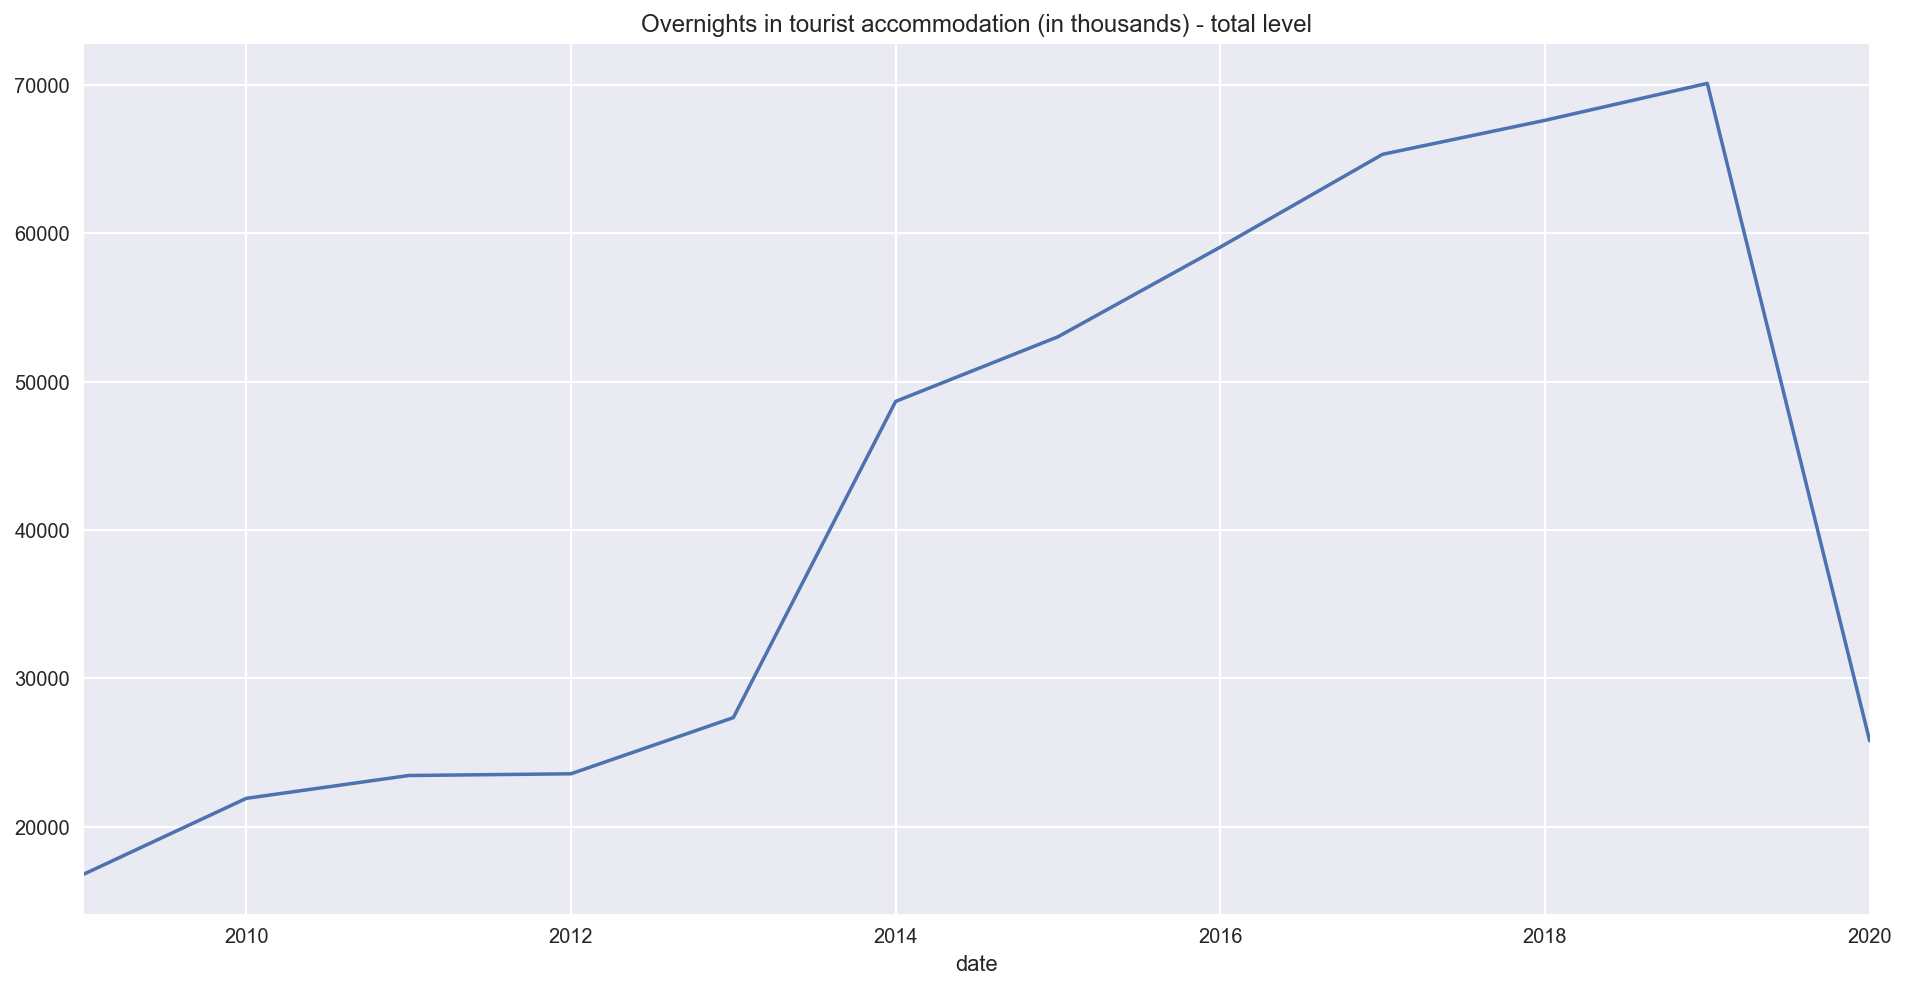

In [13]:
hierarchy_data["total"].plot(title="Overnights in tourist accommodation (in thousands) - total level");

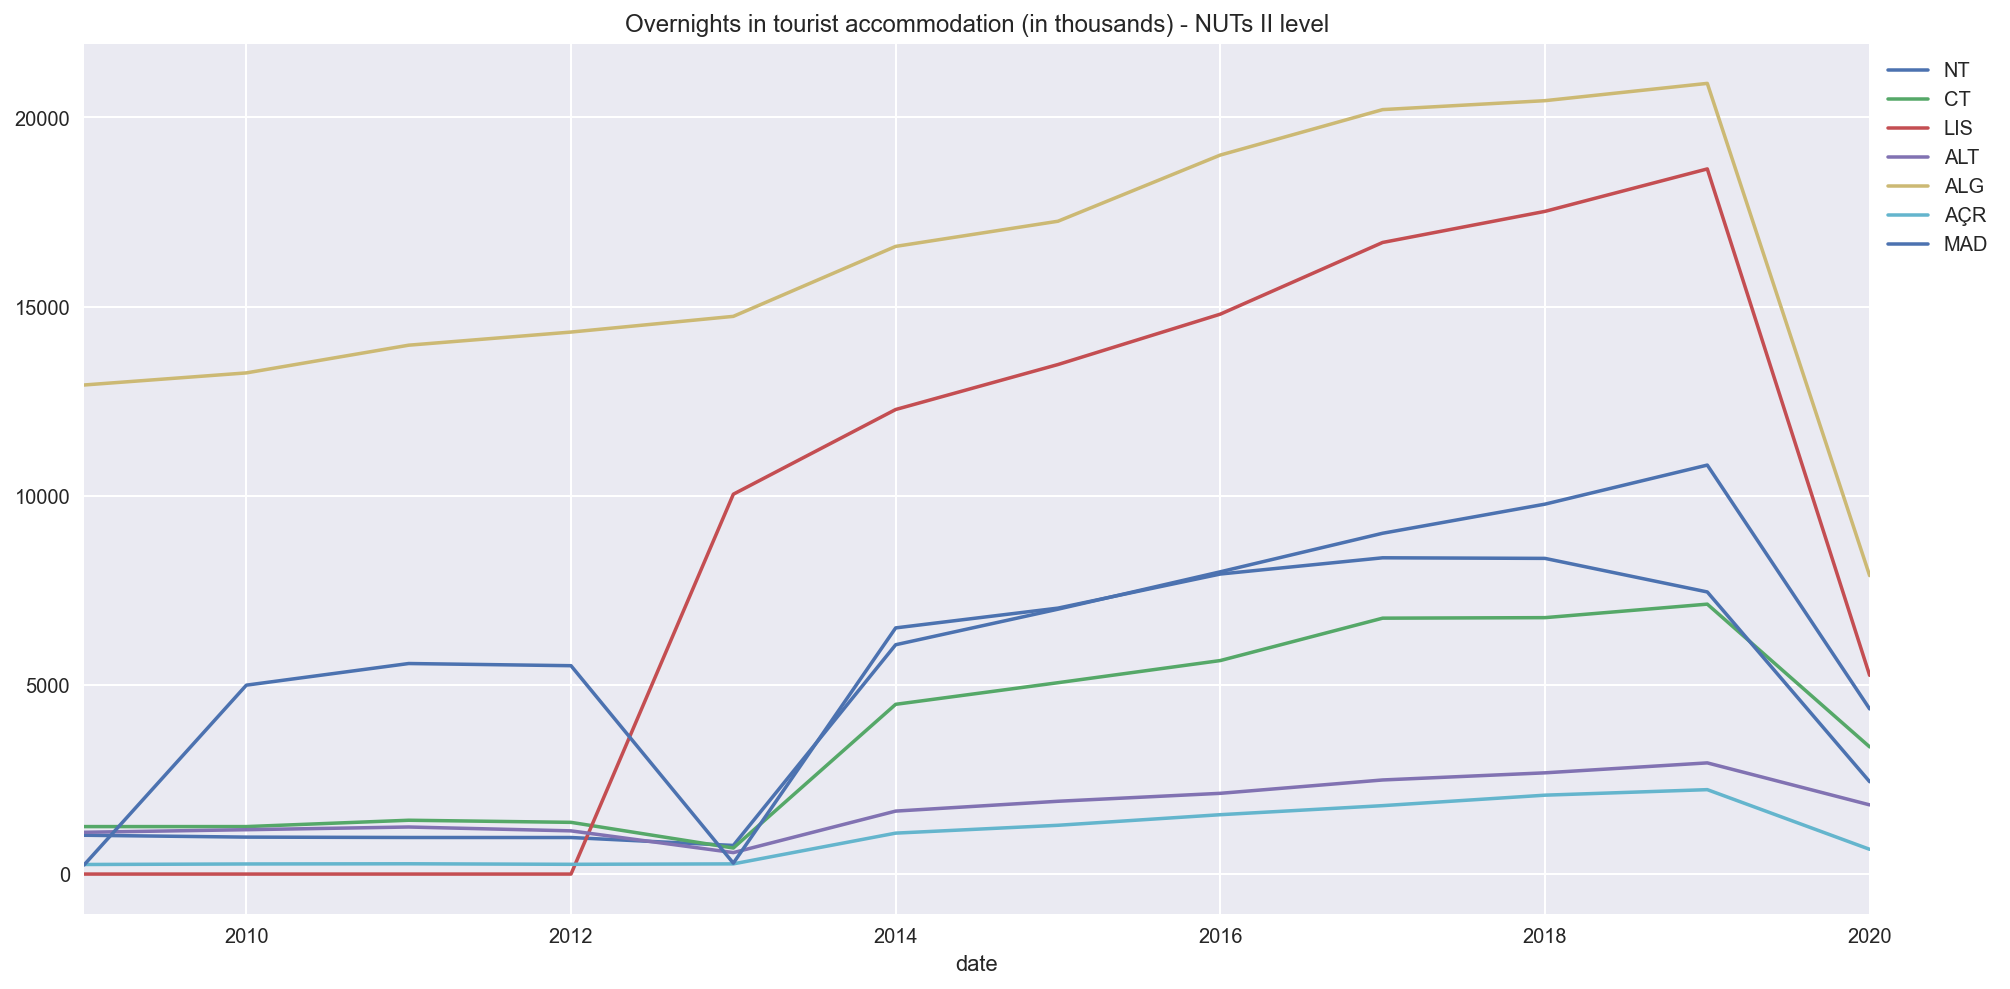

In [14]:
ax = hierarchy_data[hierarchy['total']].plot(title="Overnights in tourist accommodation (in thousands) - NUTs II level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [15]:
ax = hierarchy_data[hierarchy['NT']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Norte")
ax.legend(bbox_to_anchor=(1.0, 1.0));

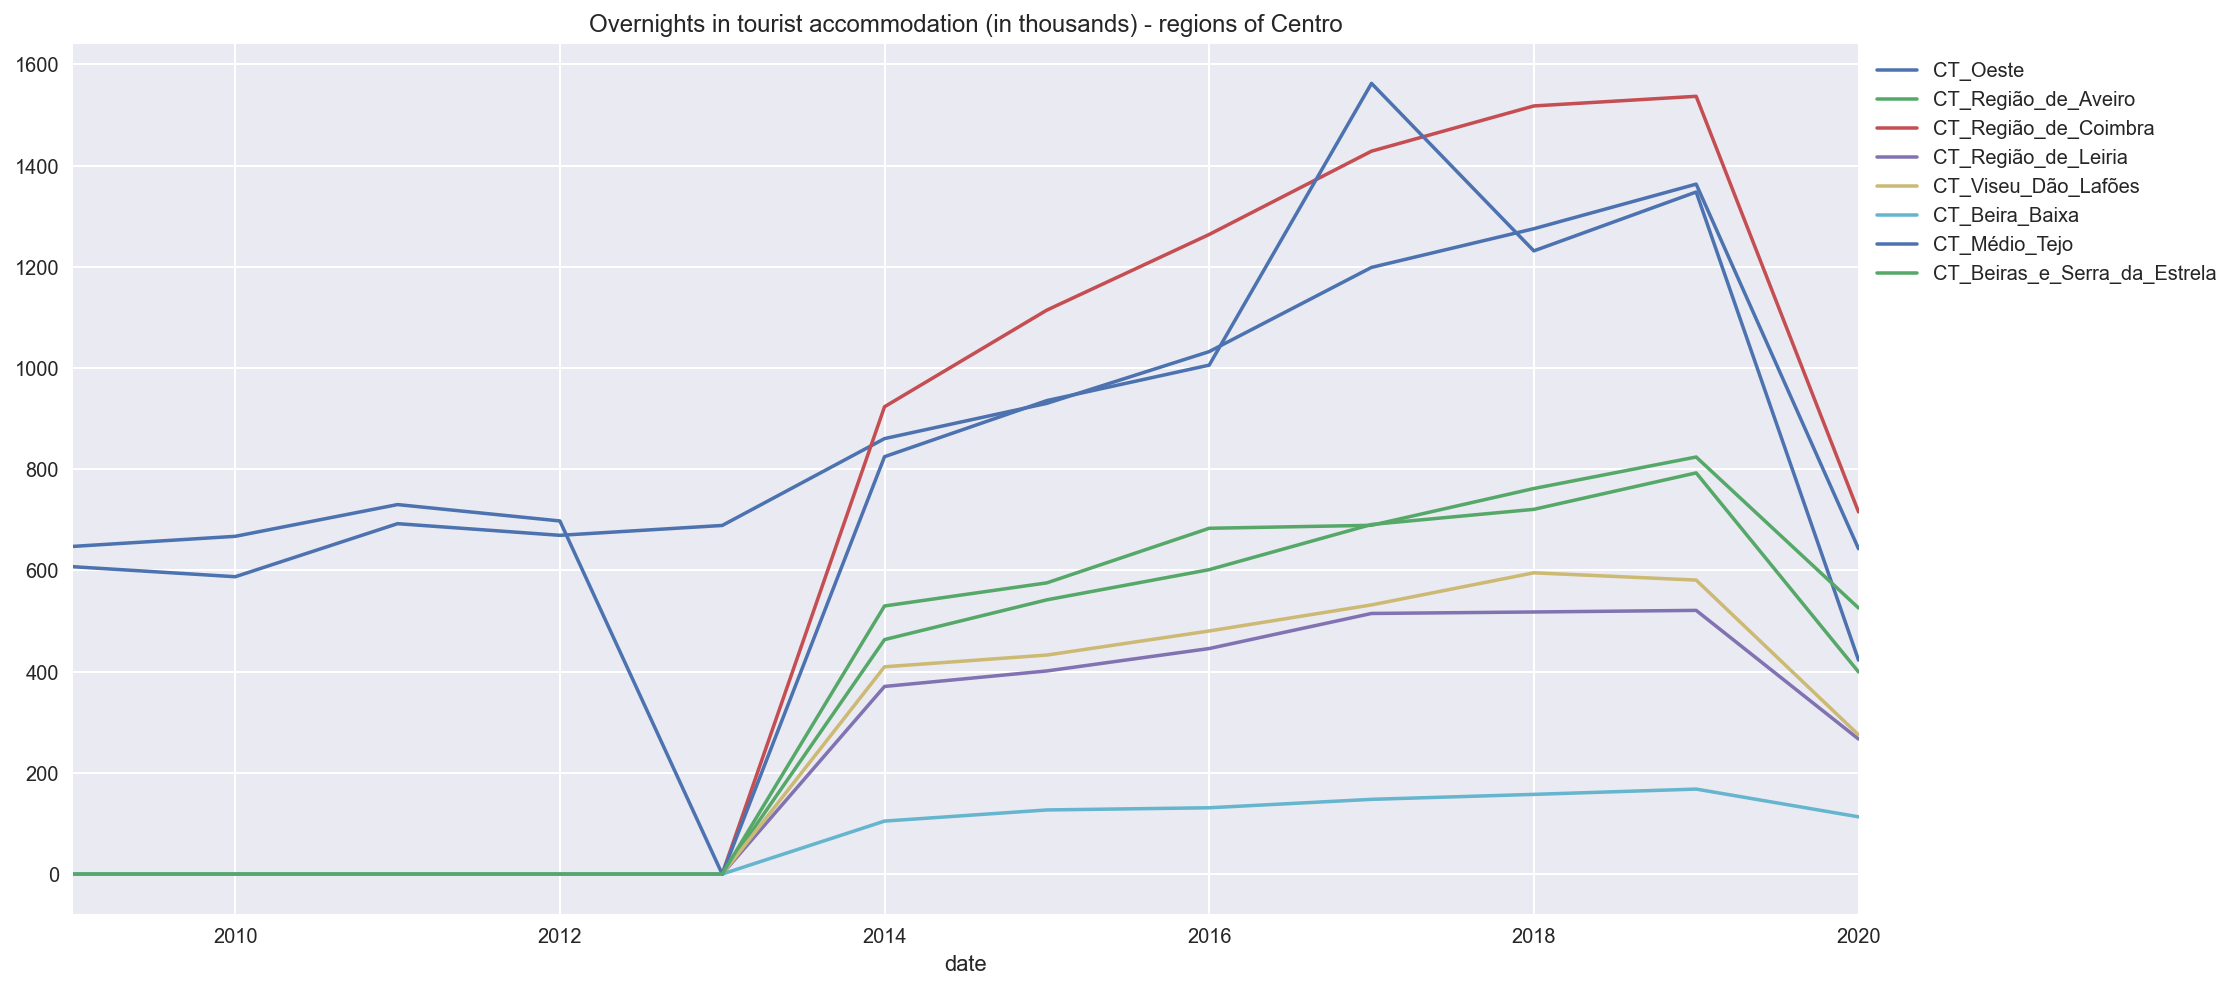

In [16]:
ax = hierarchy_data[hierarchy['CT']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Centro")
ax.legend(bbox_to_anchor=(1.0, 1.0));

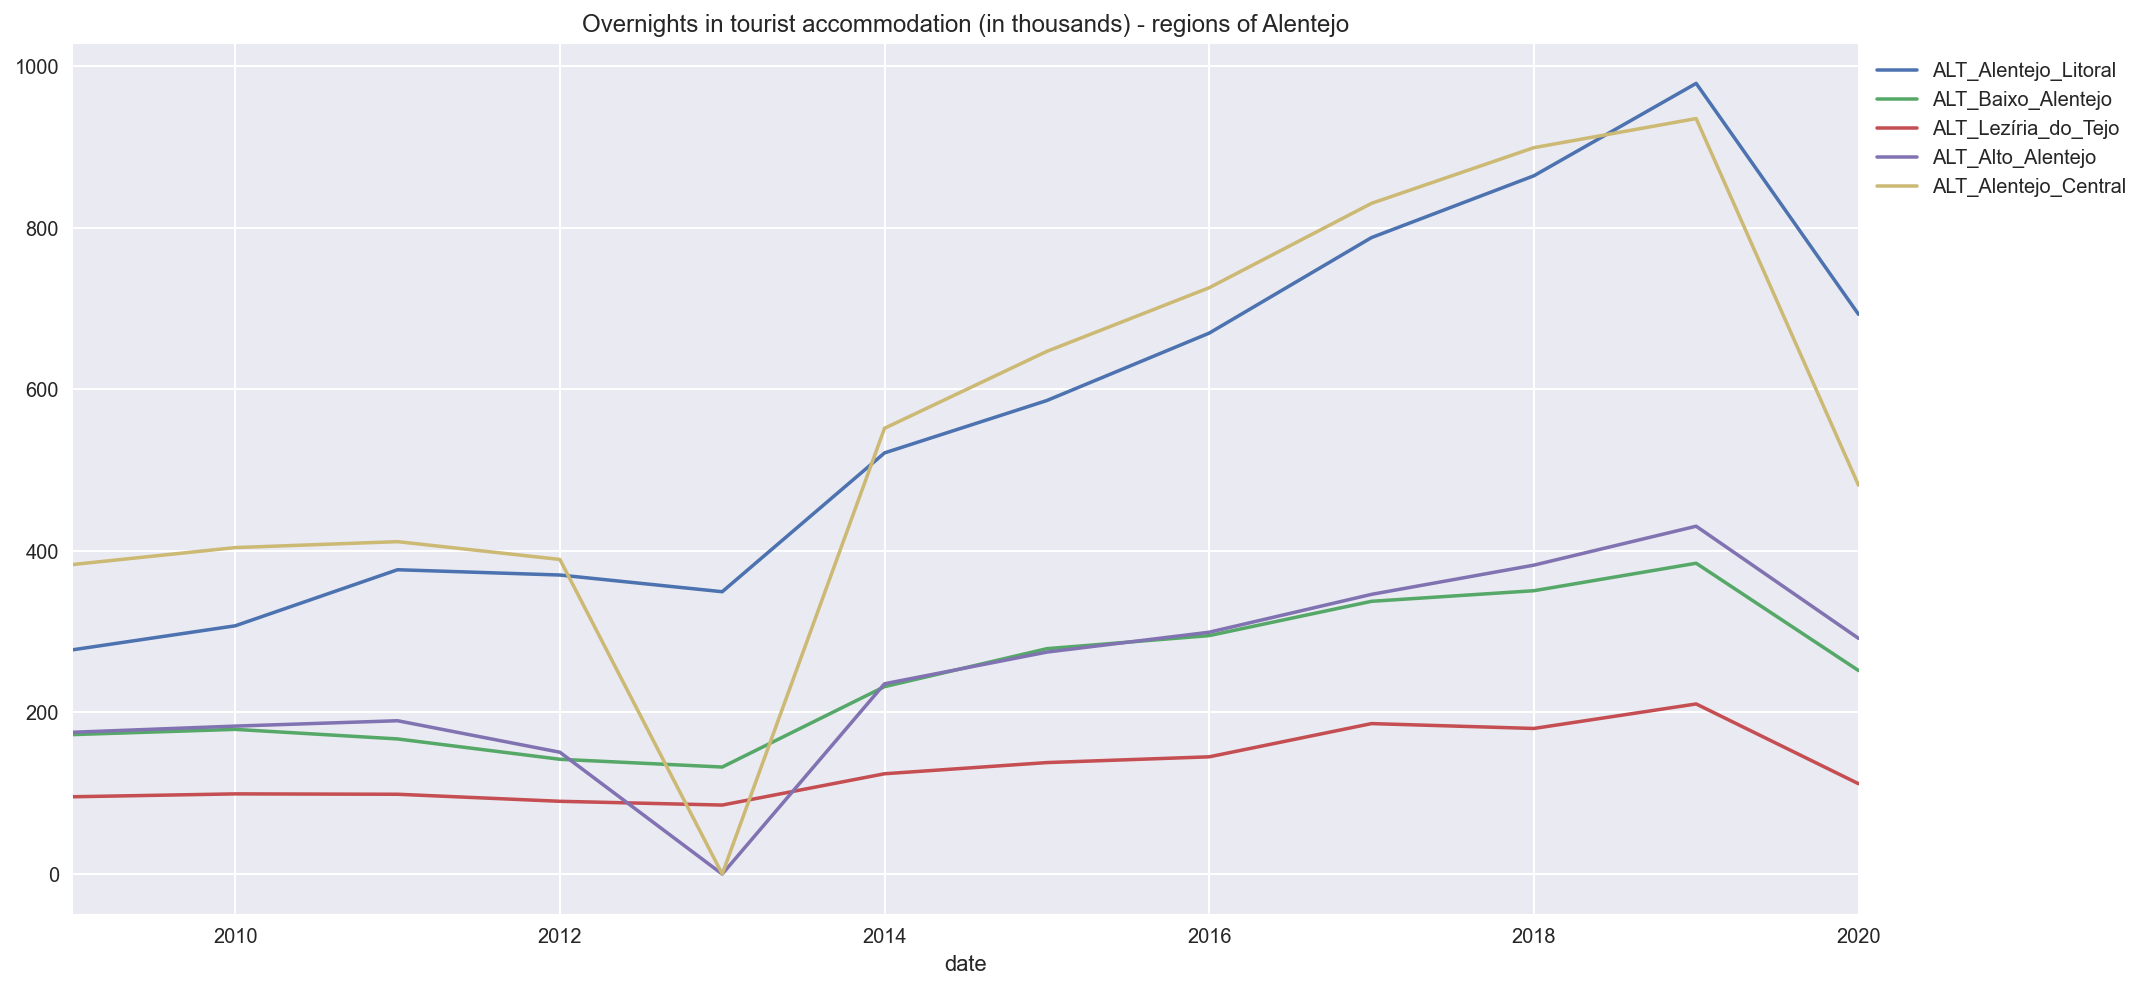

In [17]:
ax = hierarchy_data[hierarchy['ALT']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Alentejo")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [18]:
ax = hierarchy_data[hierarchy['LIS']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Lisboa")
ax.legend(bbox_to_anchor=(1.0, 1.0));

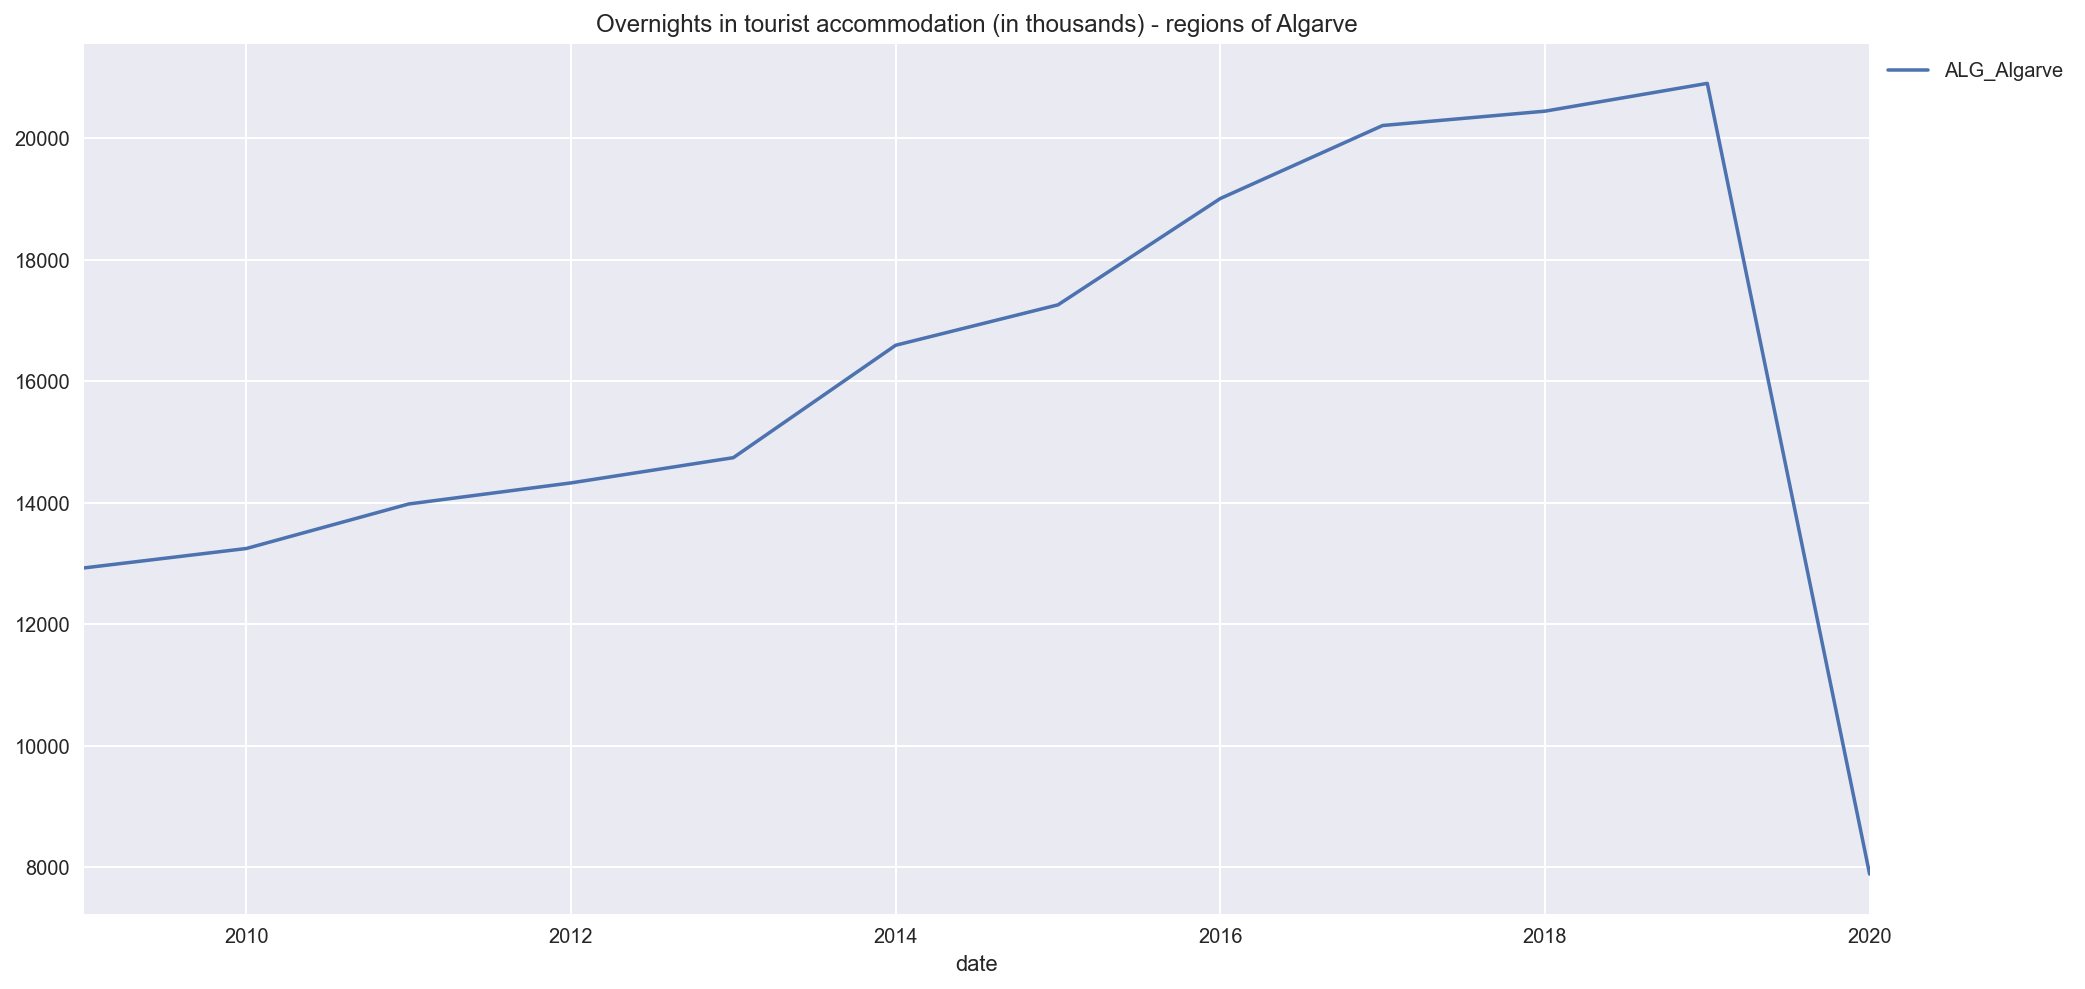

In [19]:
ax = hierarchy_data[hierarchy['ALG']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Algarve")
ax.legend(bbox_to_anchor=(1.0, 1.0));

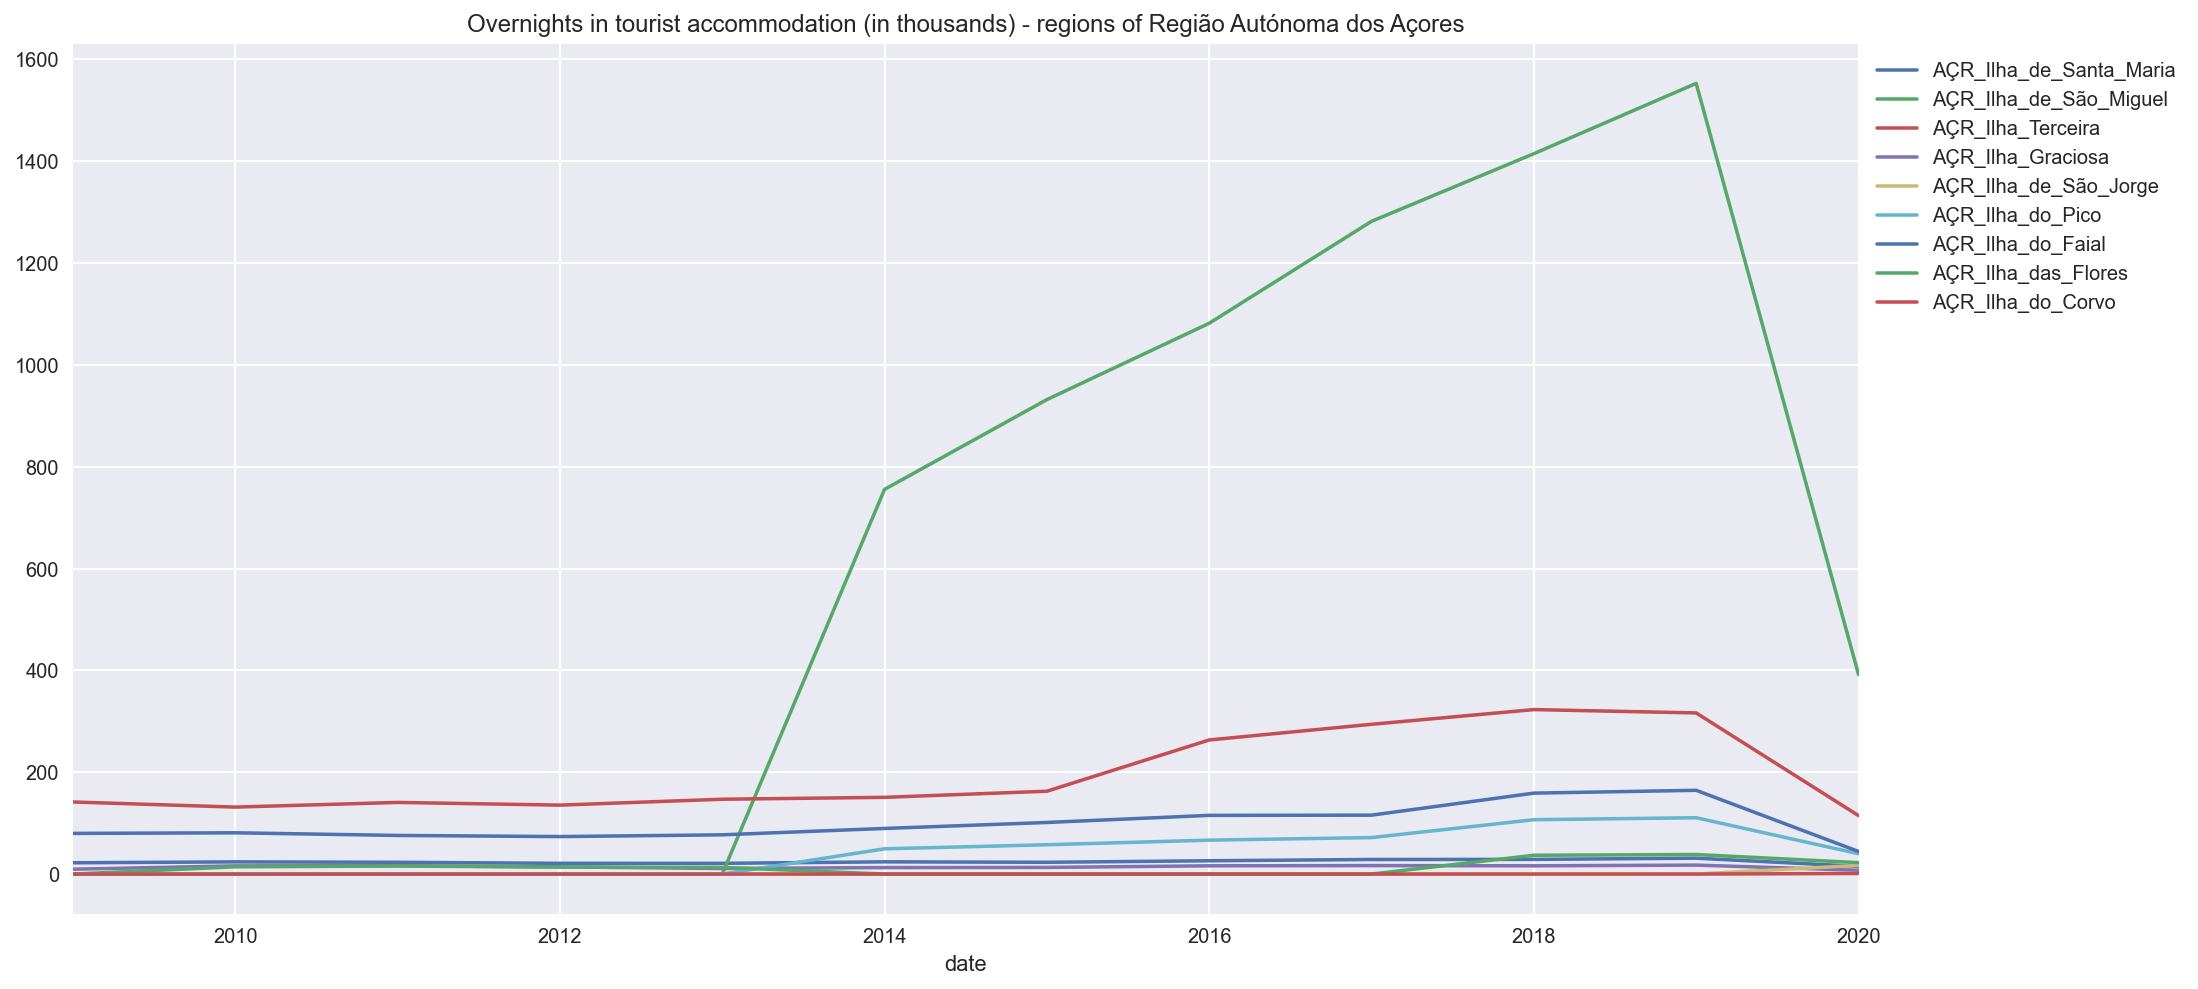

In [20]:
ax = hierarchy_data[hierarchy['AÇR']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Região Autónoma dos Açores")
ax.legend(bbox_to_anchor=(1.0, 1.0));

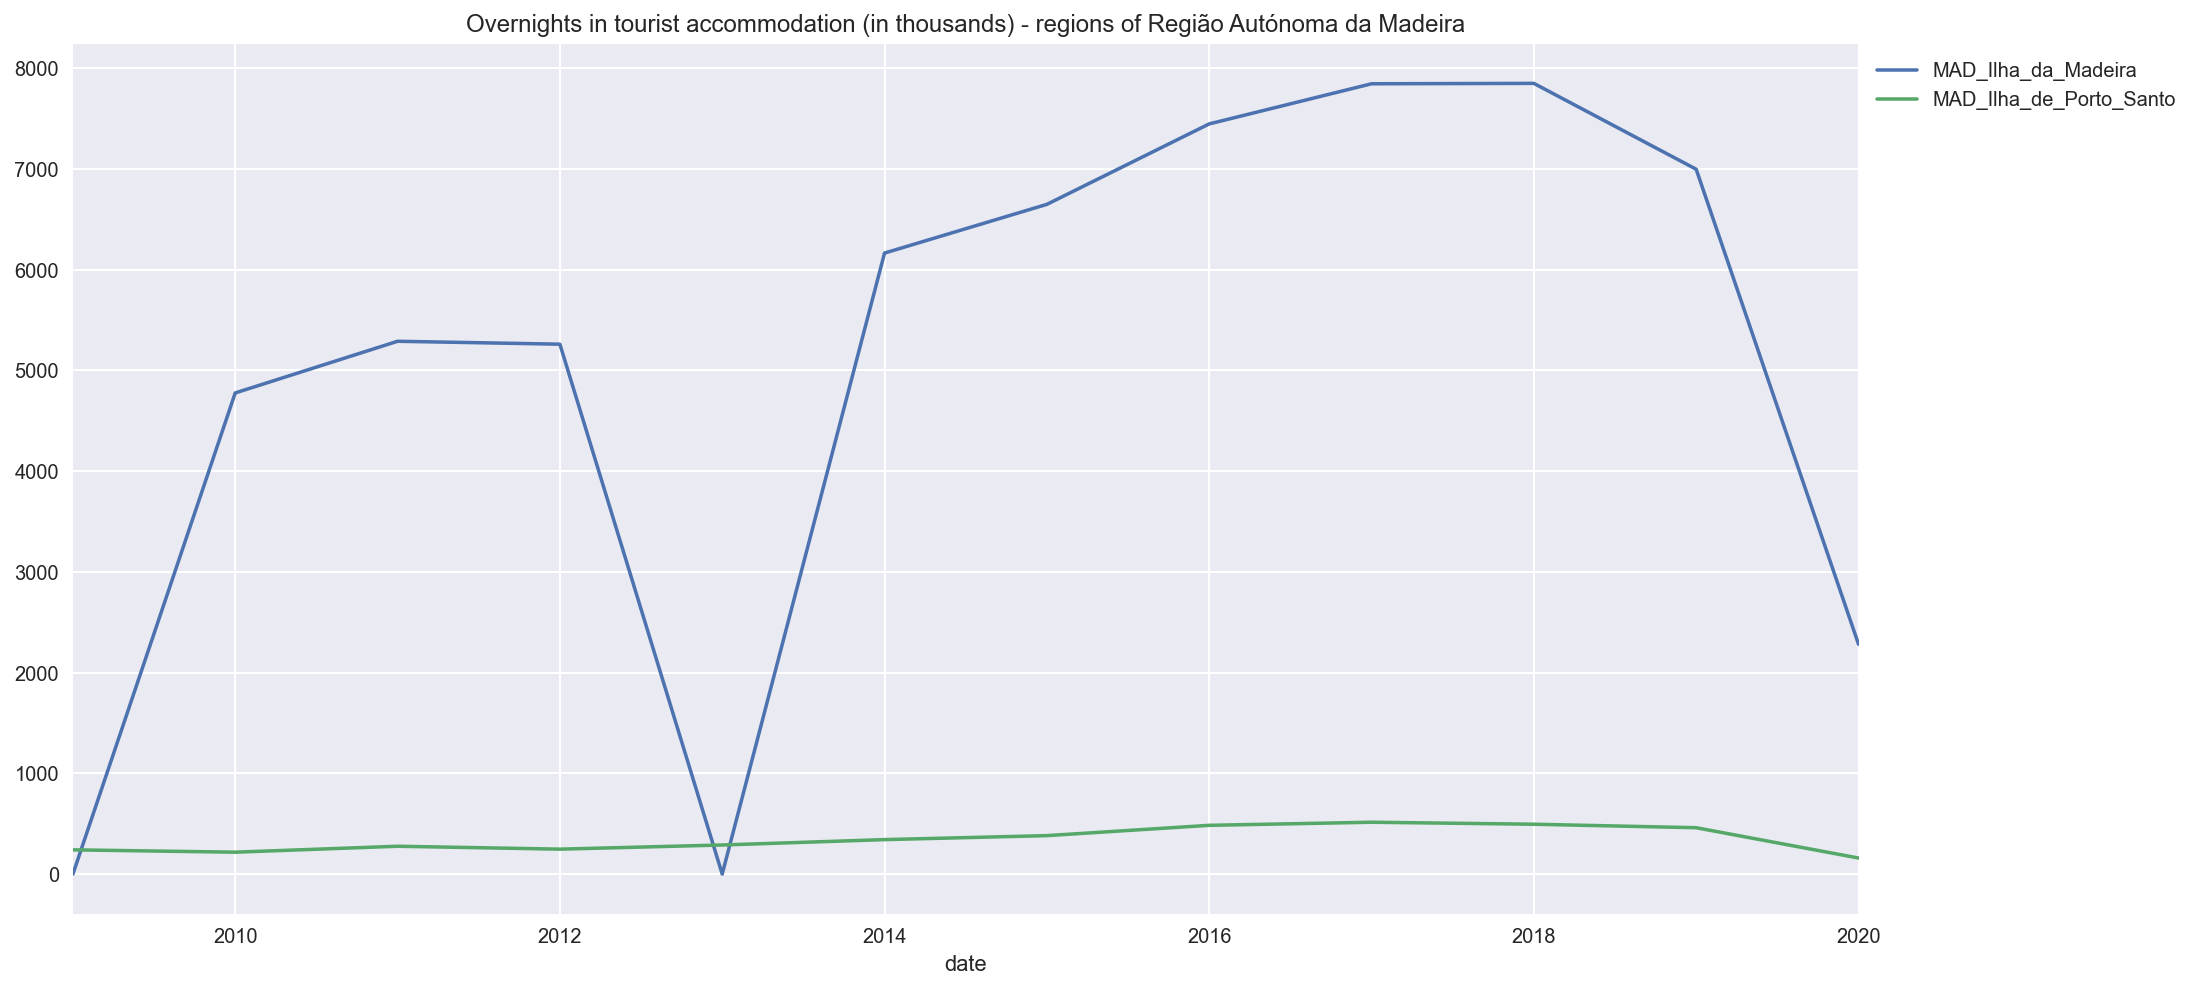

In [21]:
ax = hierarchy_data[hierarchy['MAD']].plot(title="Overnights in tourist accommodation (in thousands) - regions of Região Autónoma da Madeira")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## AUTO-ARIMA

In [22]:
clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model = clf.fit(hierarchy_data, hierarchy)

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 42/42 [00:16<00:00,  2.50it/s]


In [23]:
predicted_autoarima = model.predict(steps_ahead=4)

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 315.44it/s]


In [24]:


model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_data, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=4)



Fitting models: 100%|█████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 289.52it/s]


In [25]:
def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        hierarchy_data[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Visitors")

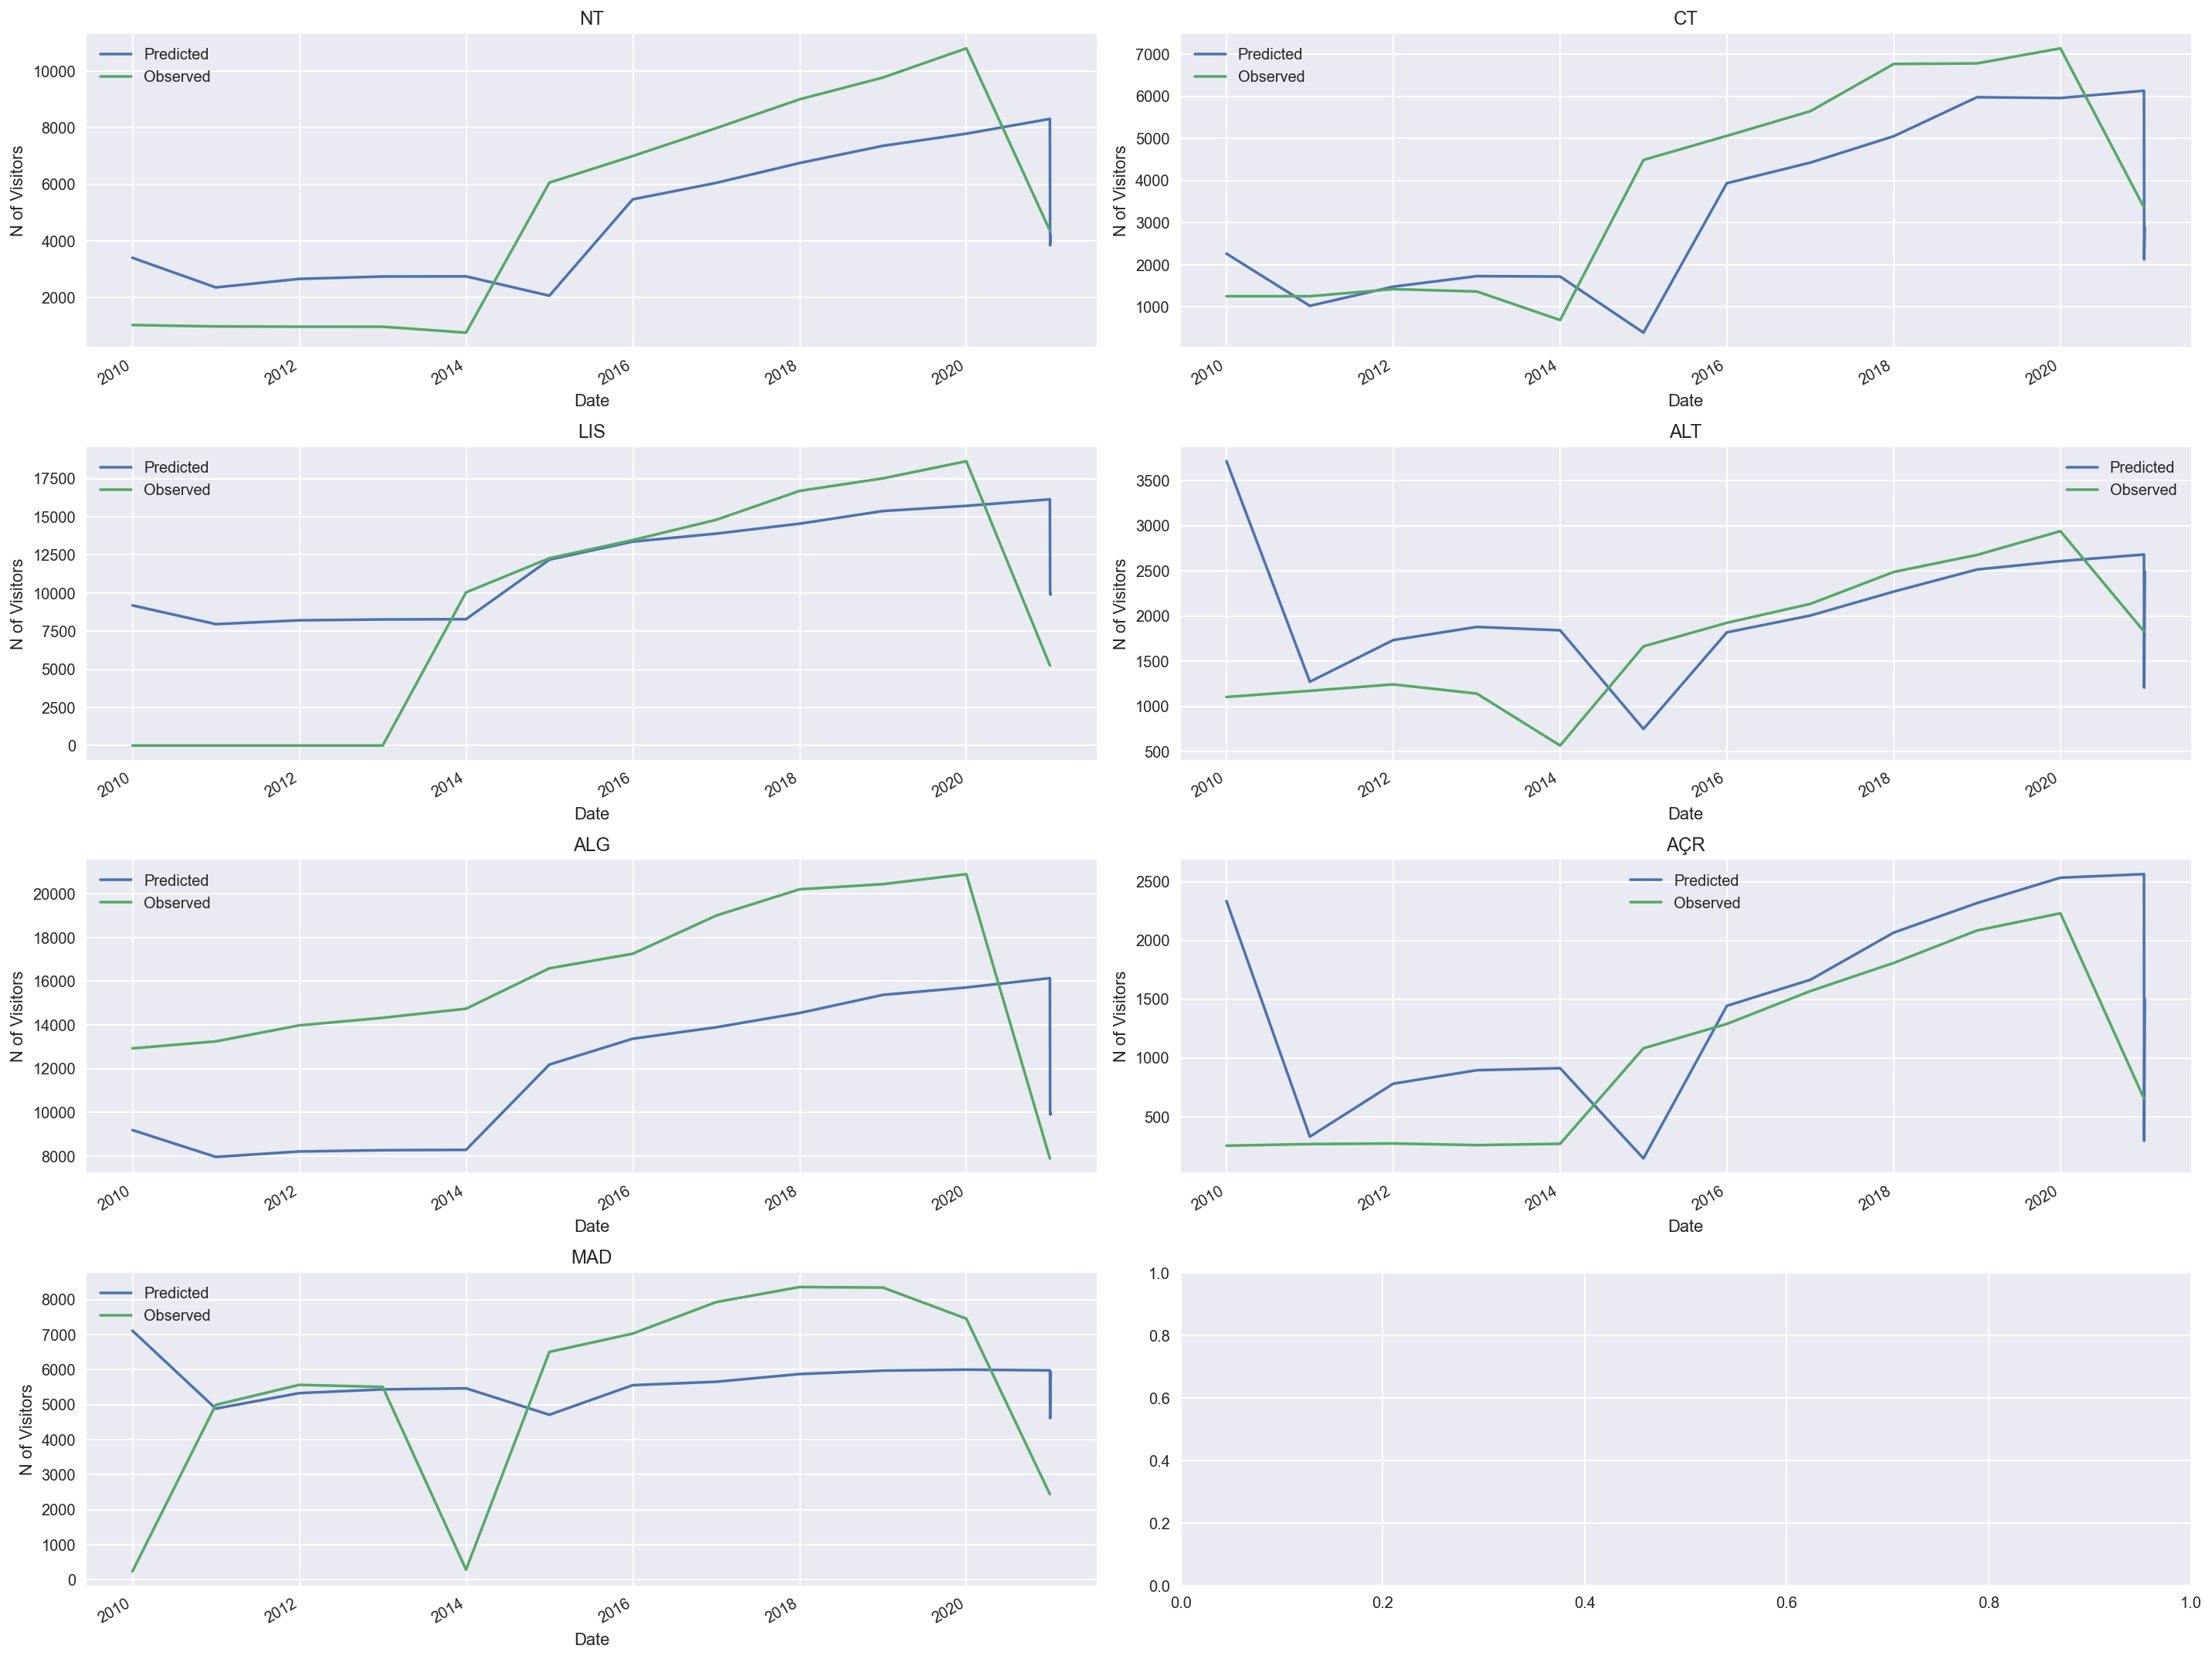

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
plot_results(nutsii, axes, predicted_autoarima)
plt.tight_layout()

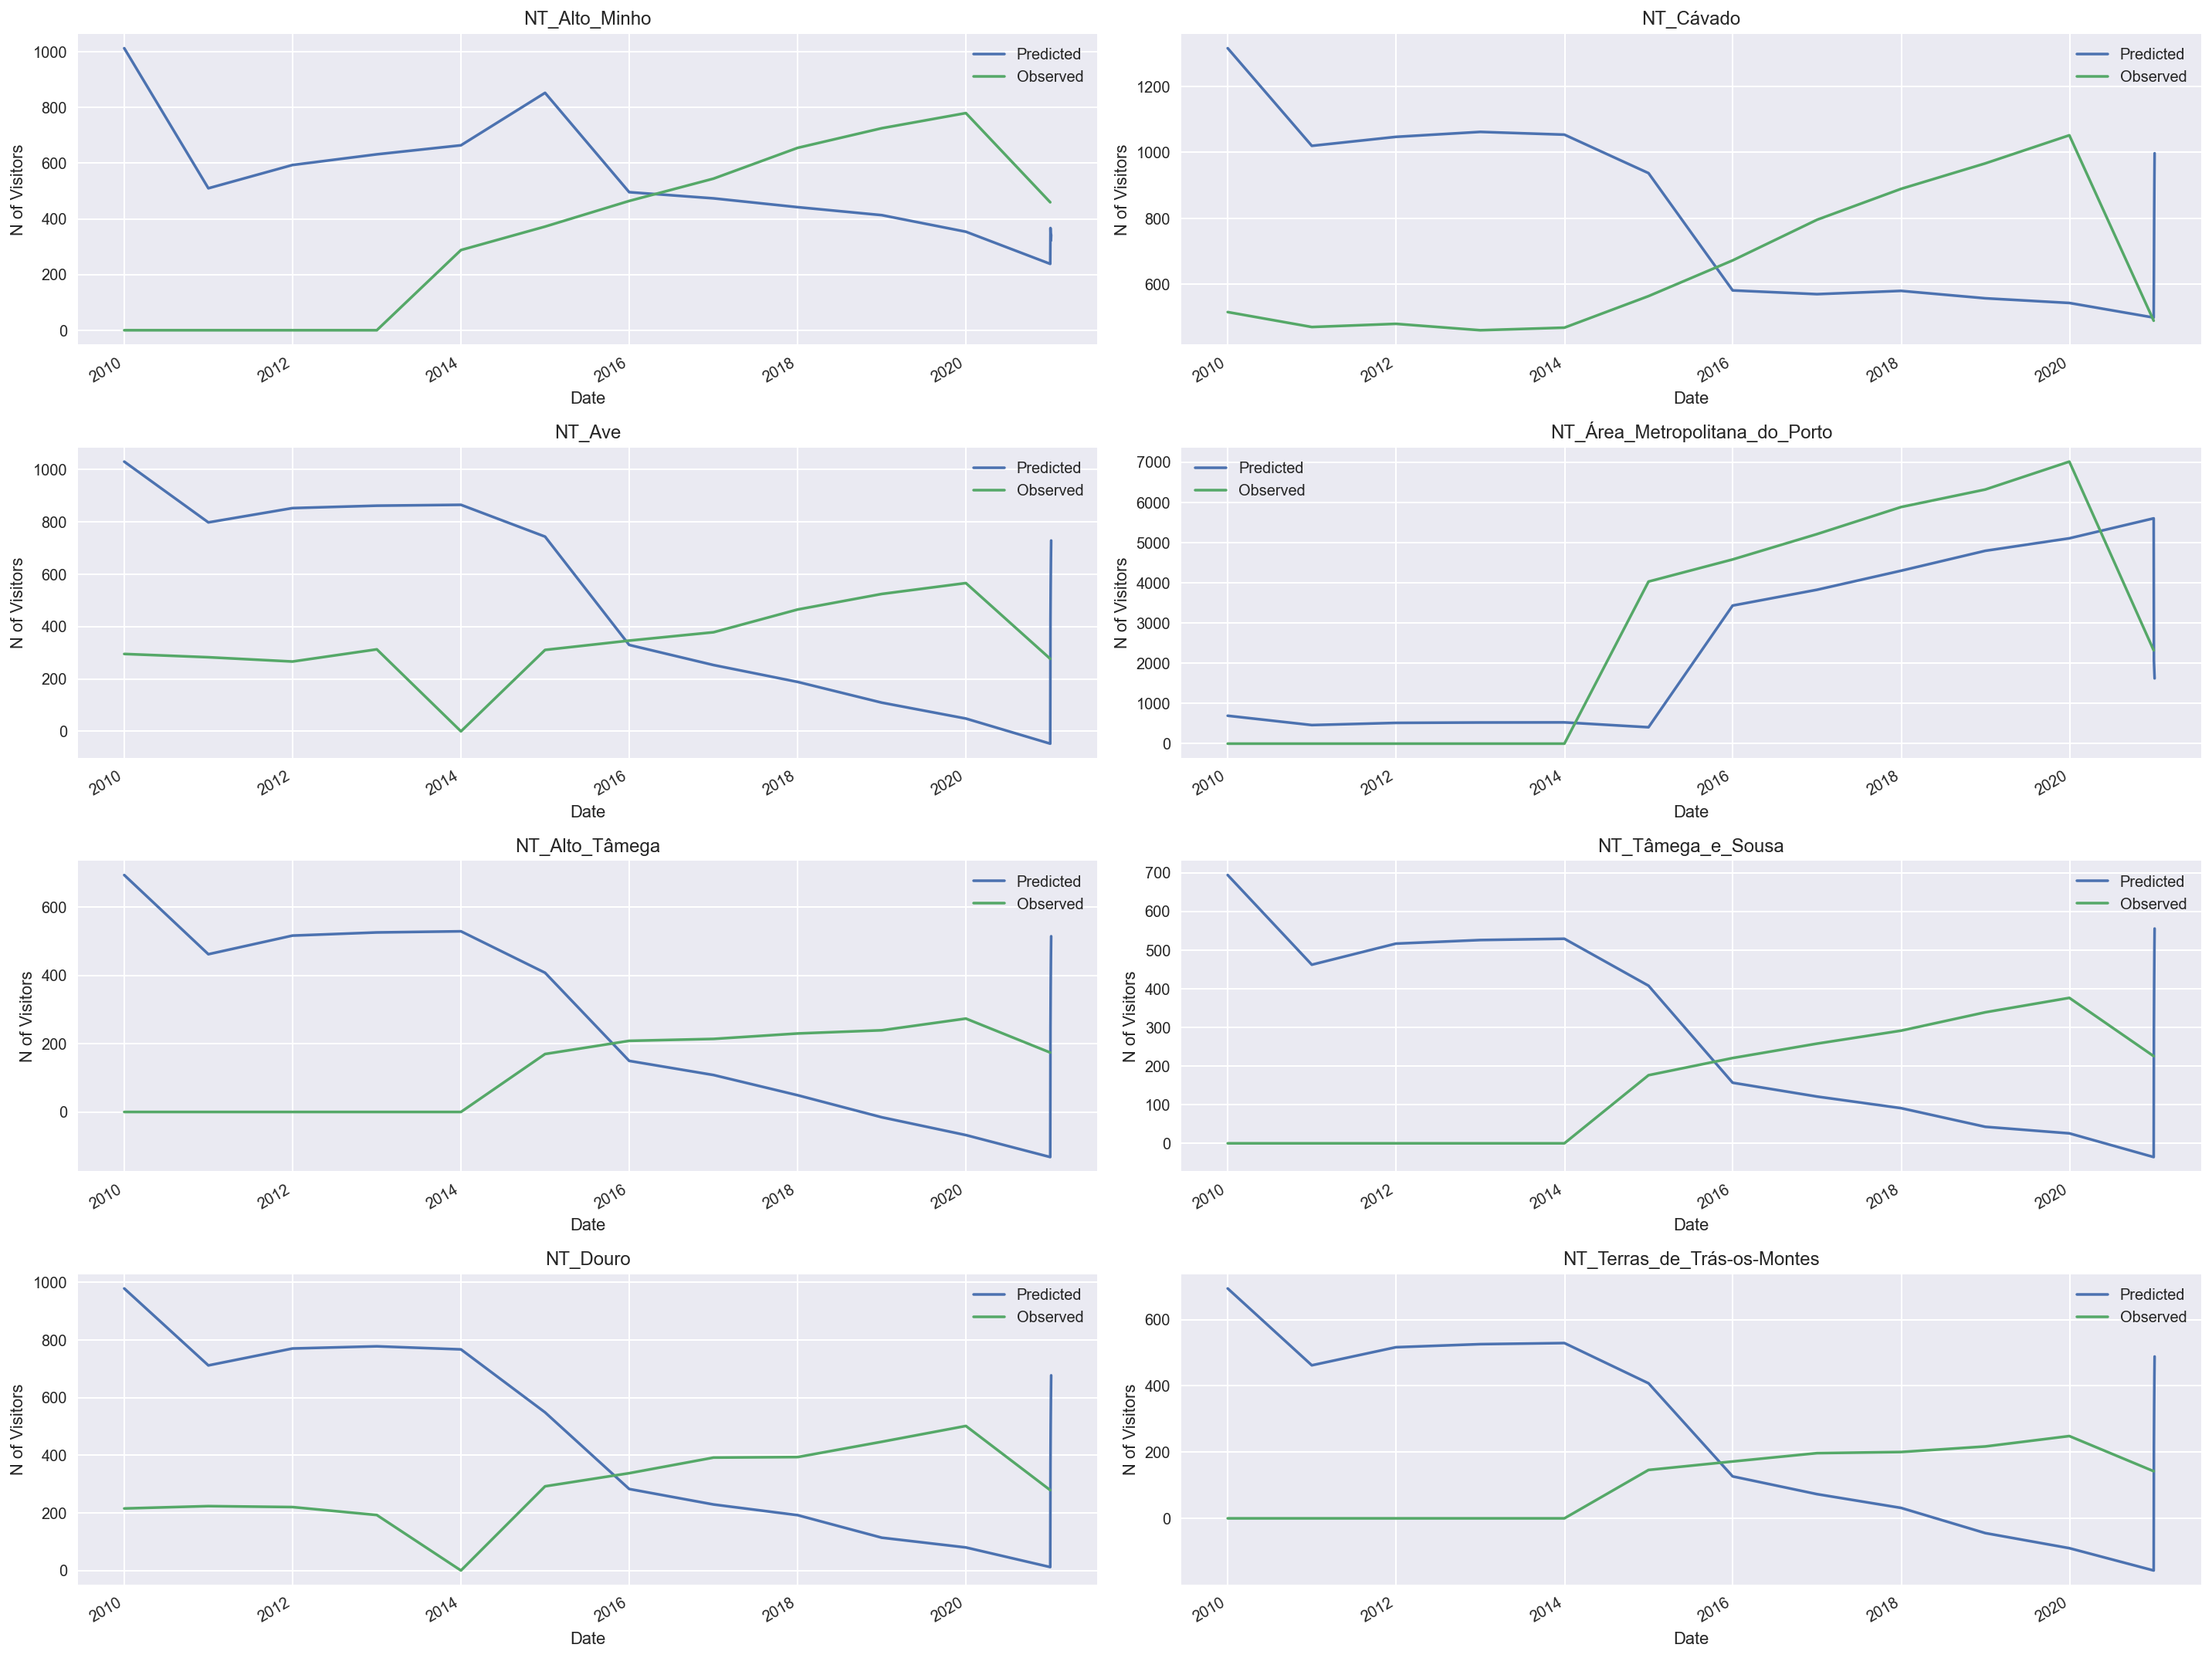

In [27]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'NT')], axes, predicted_autoarima)
plt.tight_layout()

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'CT')], axes, predicted_autoarima)
plt.tight_layout()

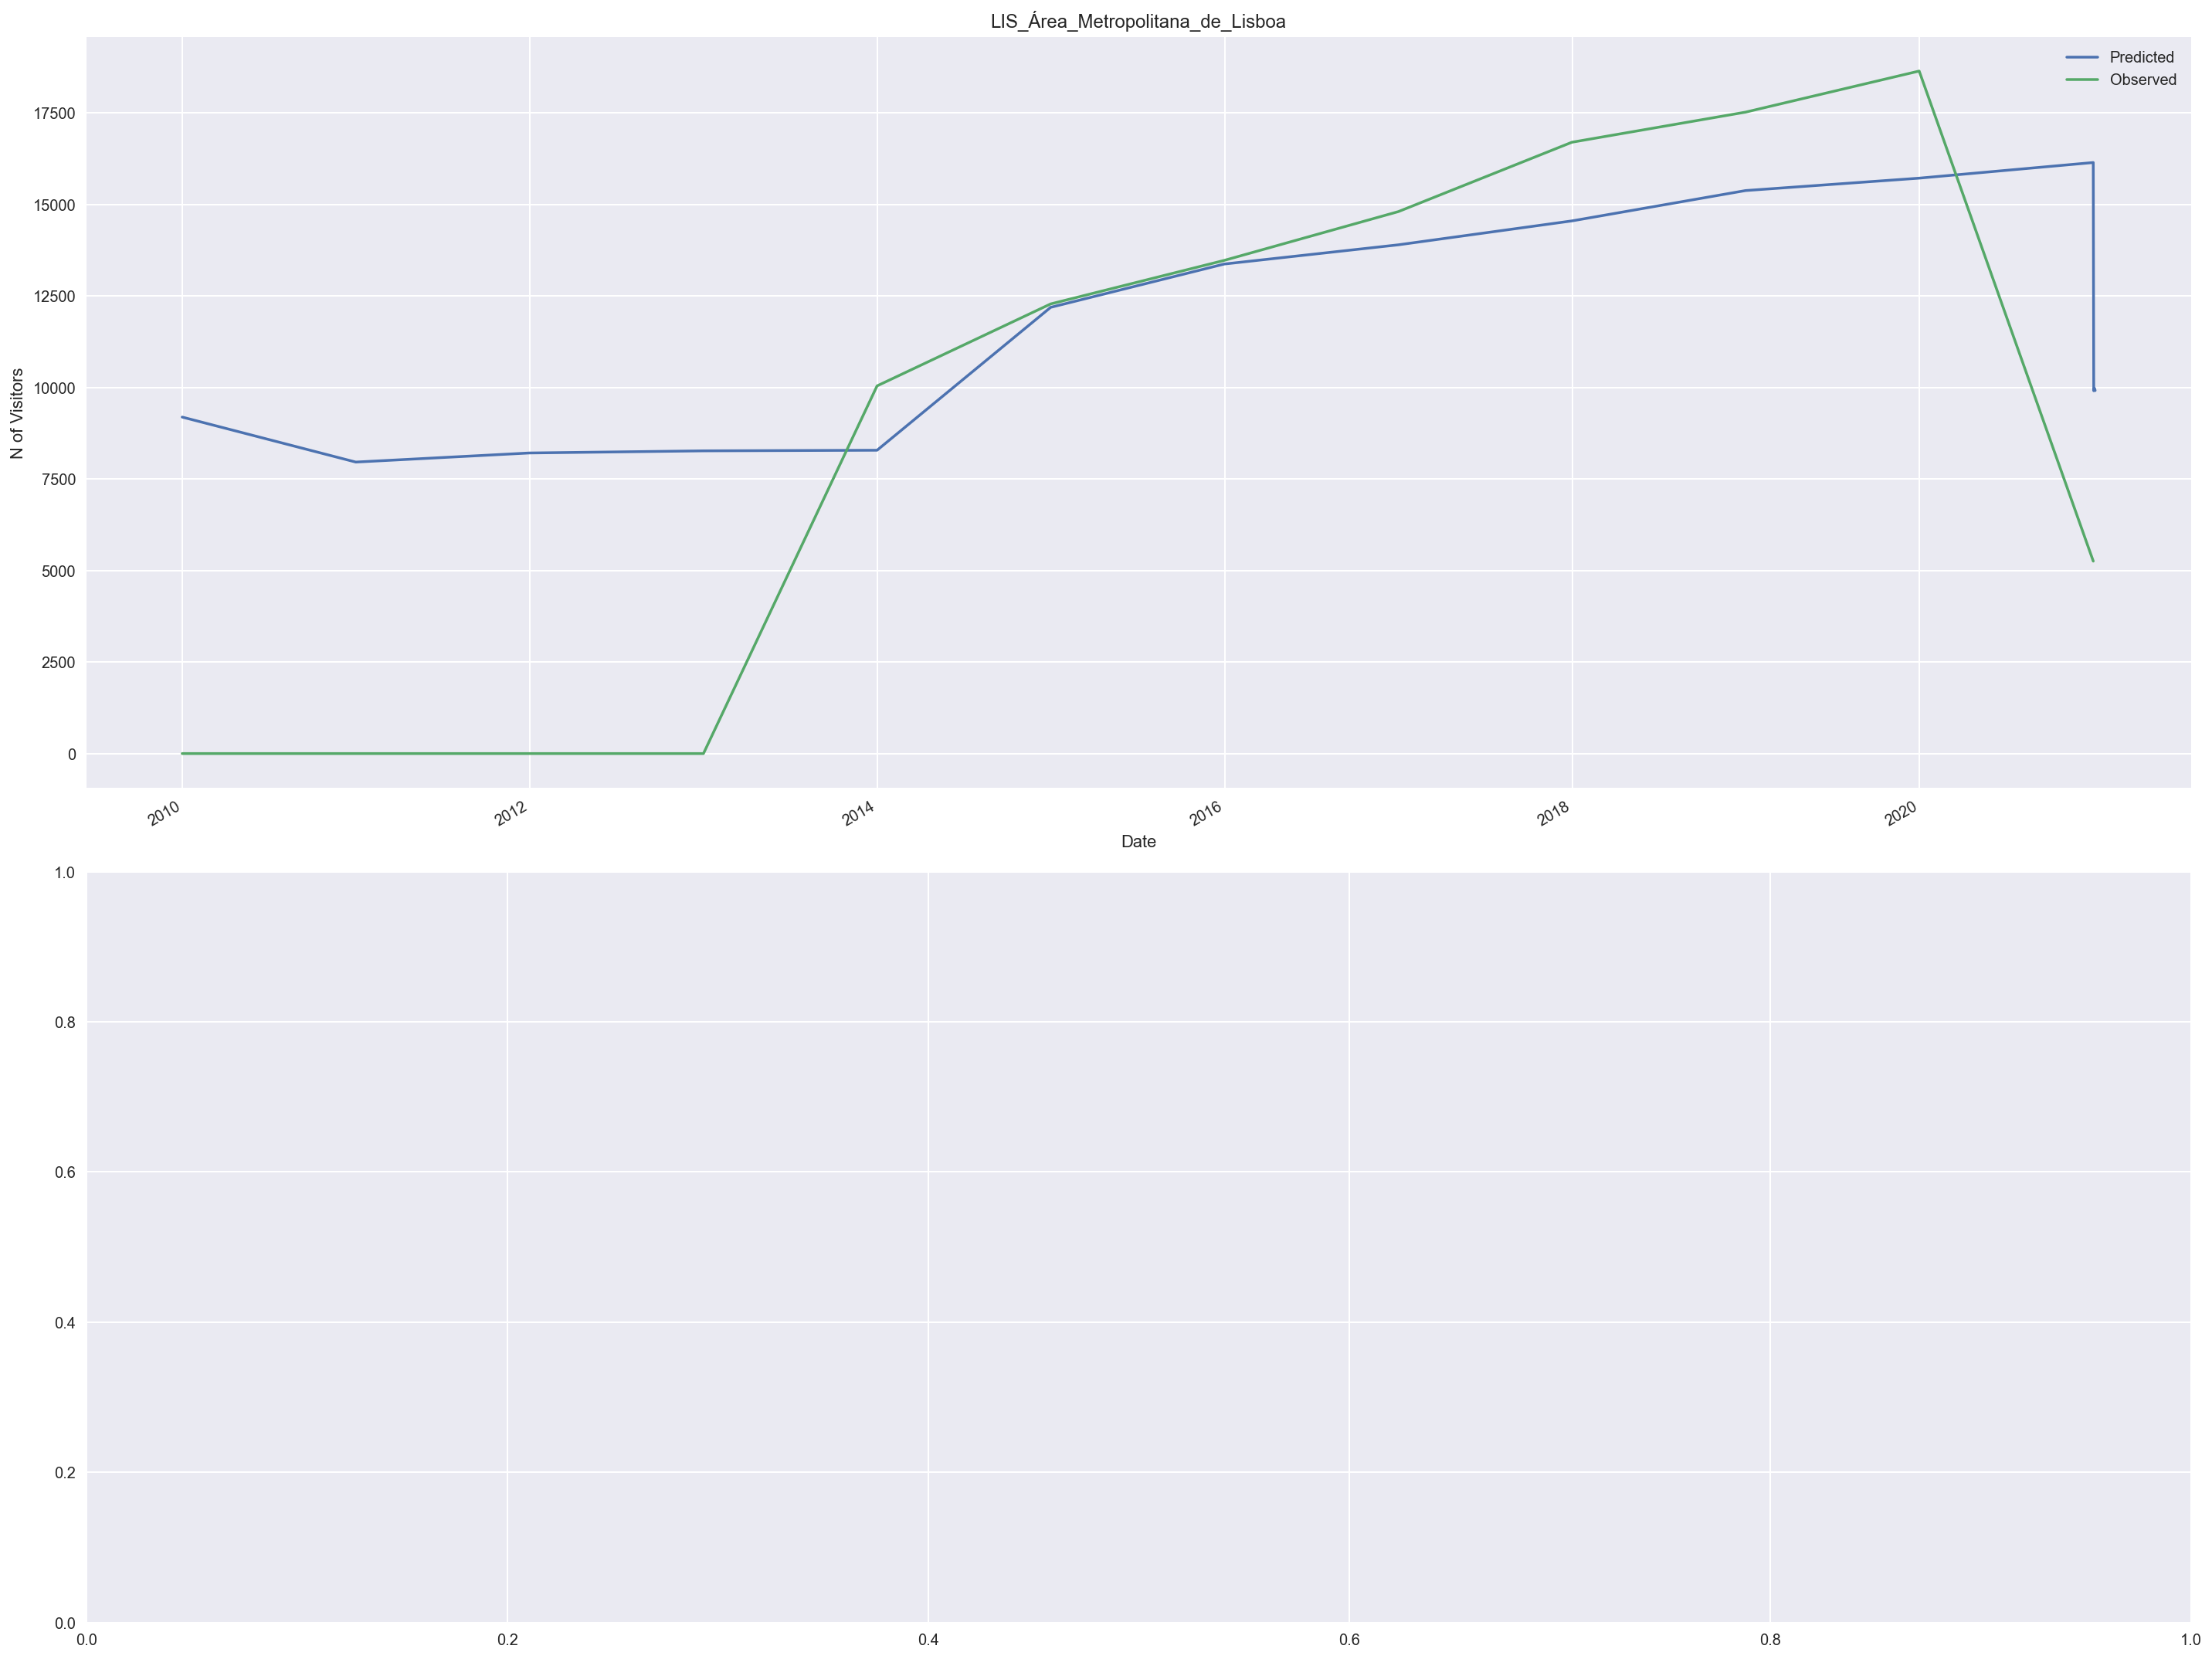

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'LIS')], axes, predicted_autoarima)
plt.tight_layout()

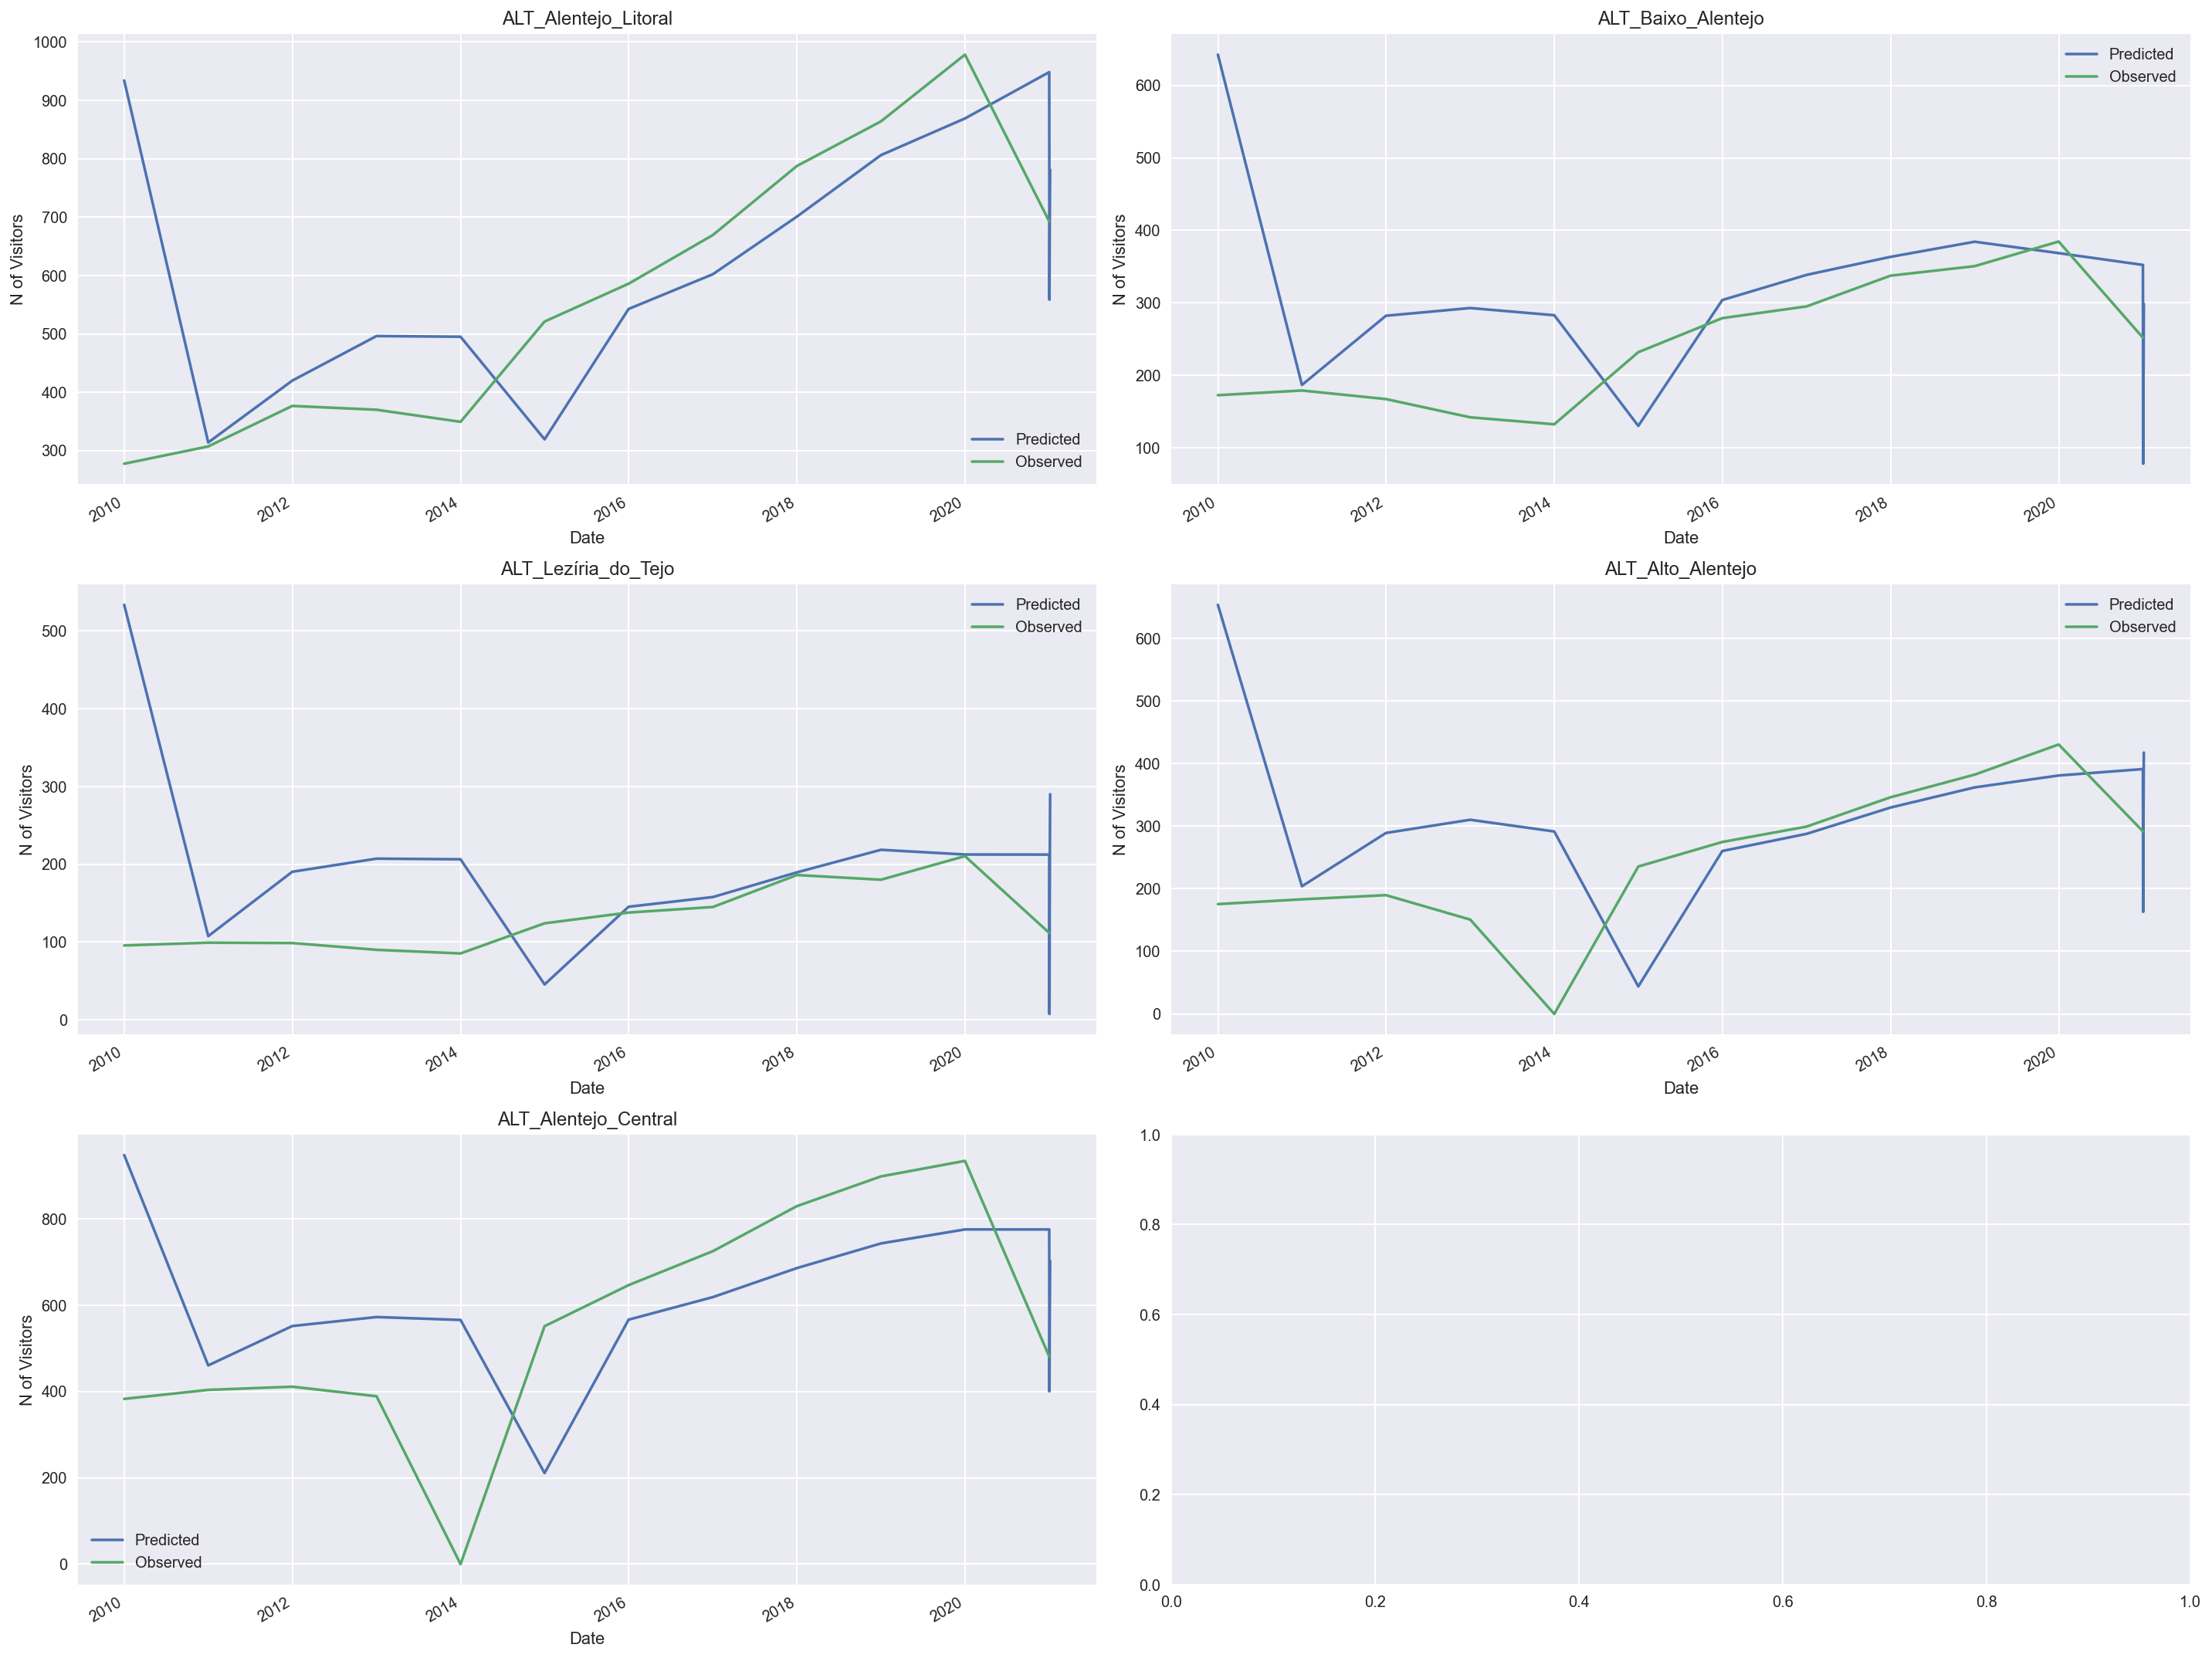

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'ALT')], axes, predicted_autoarima)
plt.tight_layout()

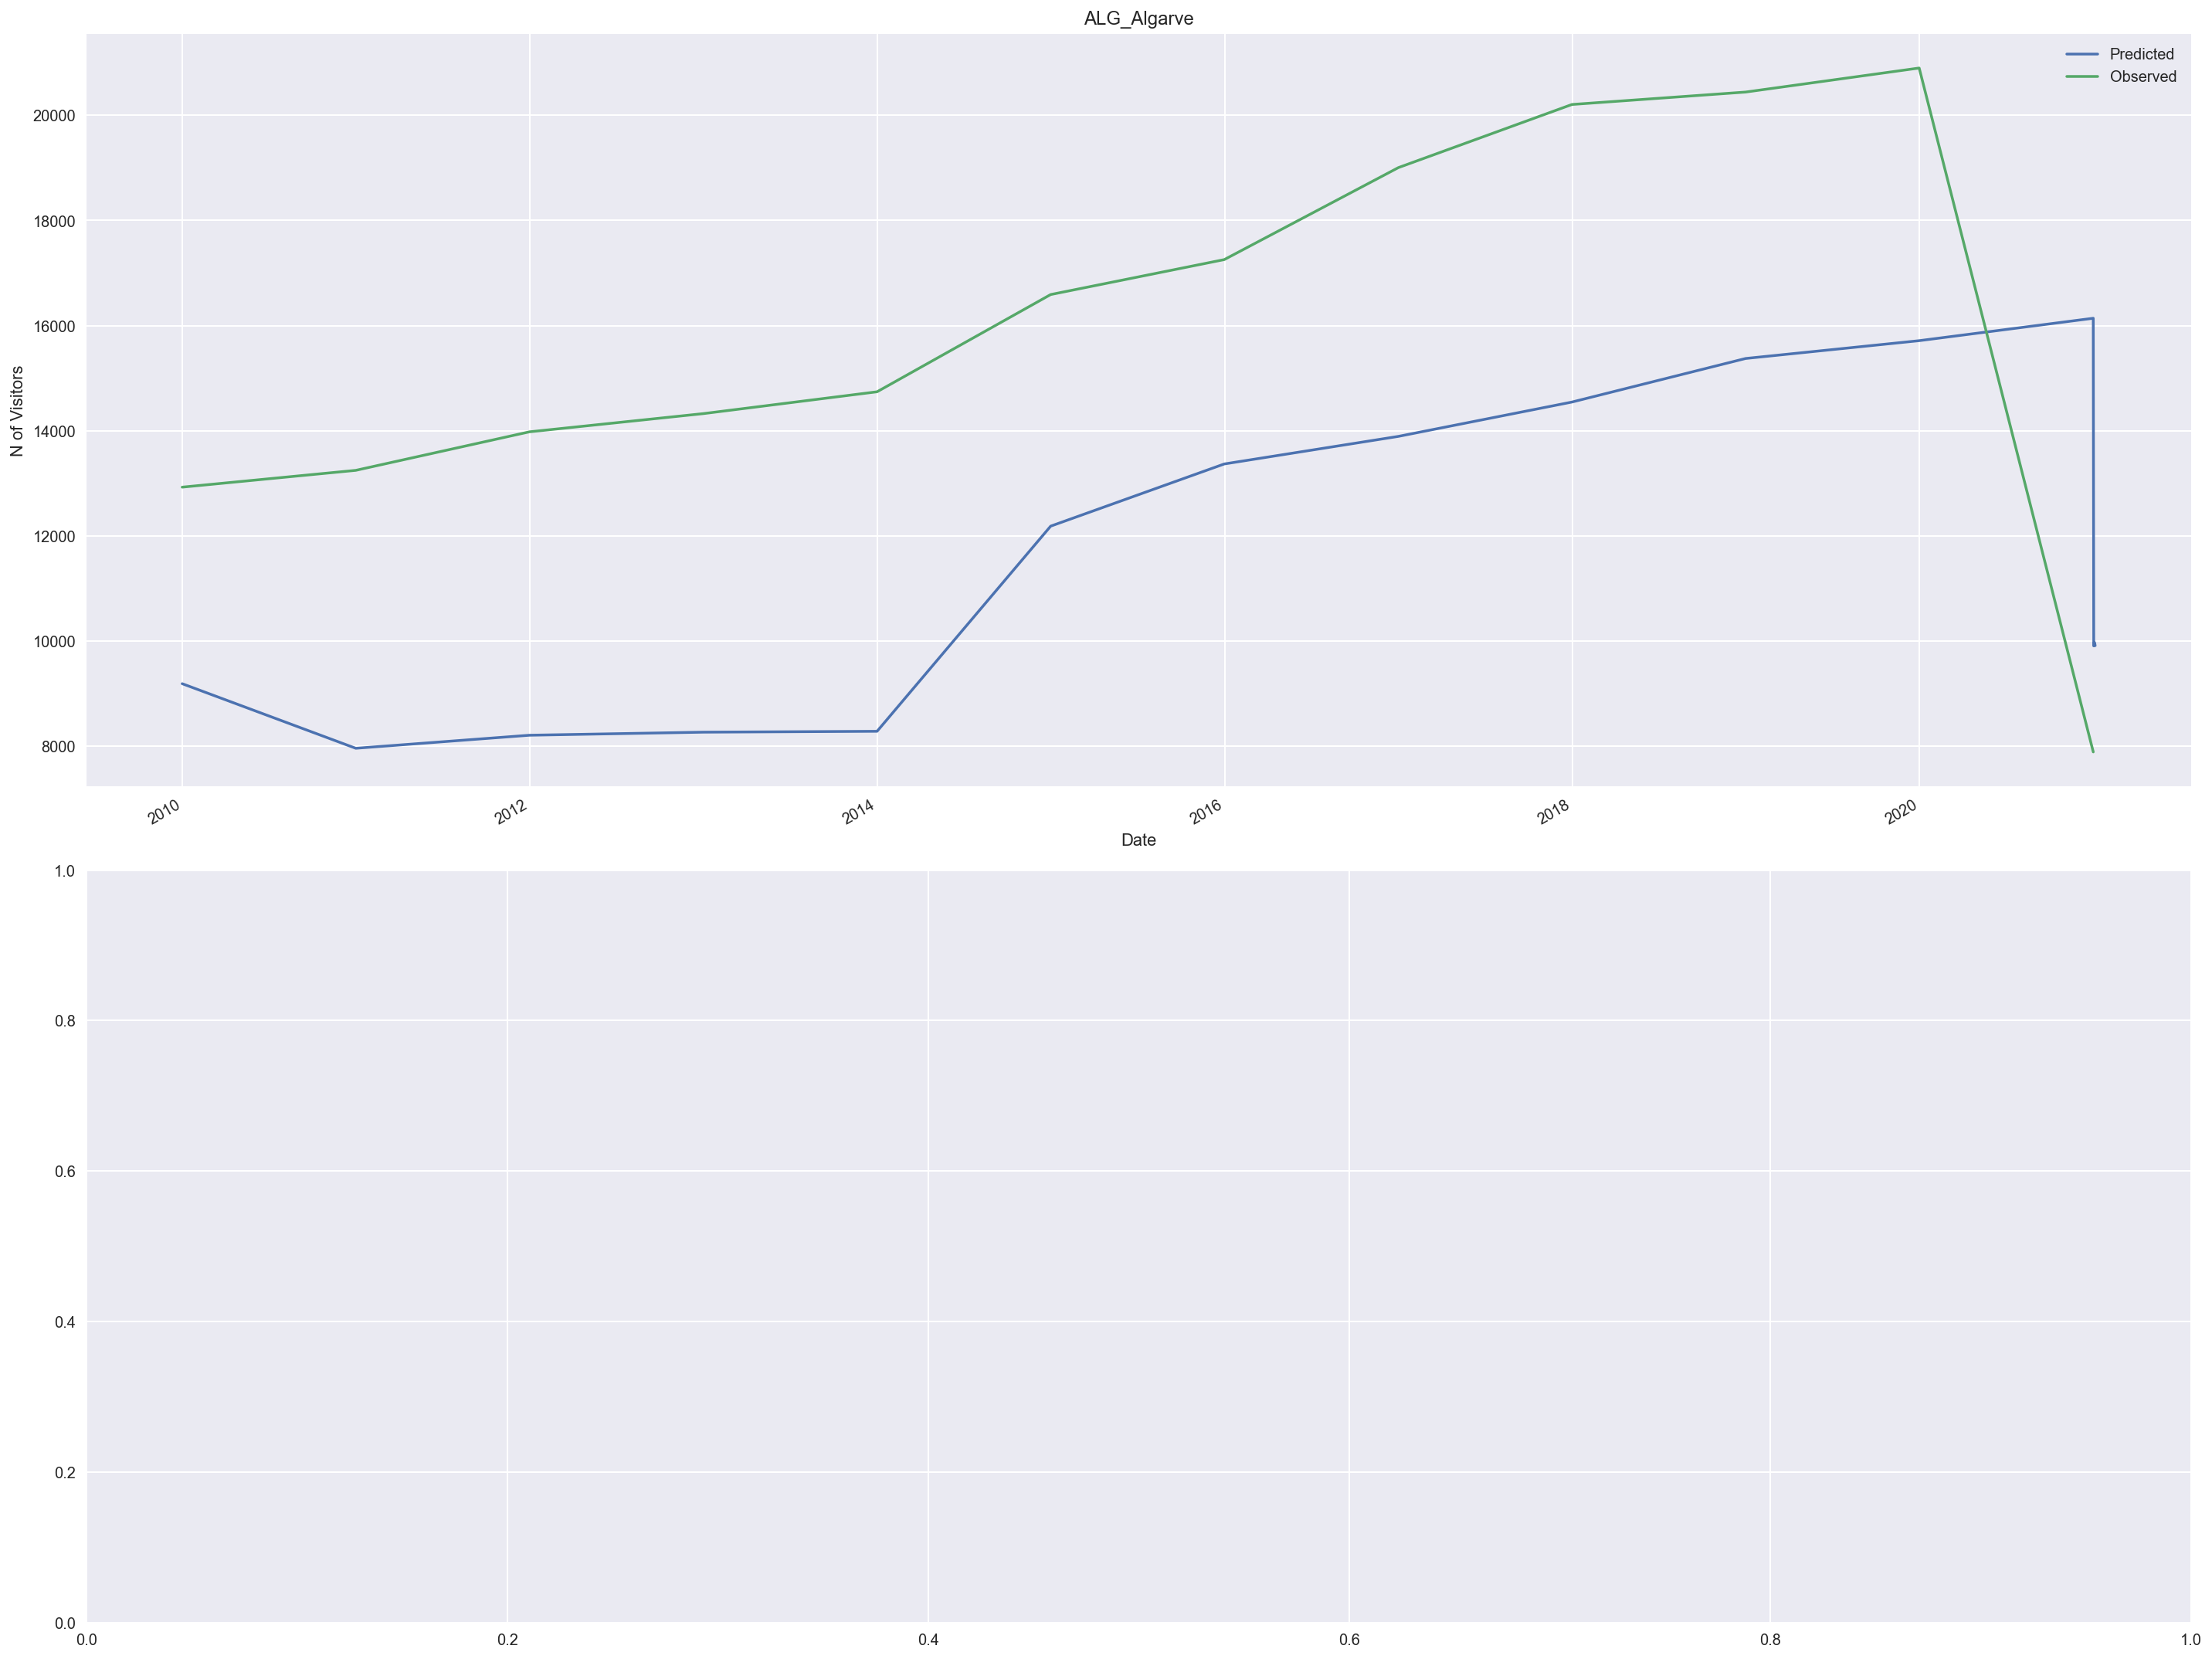

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'ALG')], axes, predicted_autoarima)
plt.tight_layout()

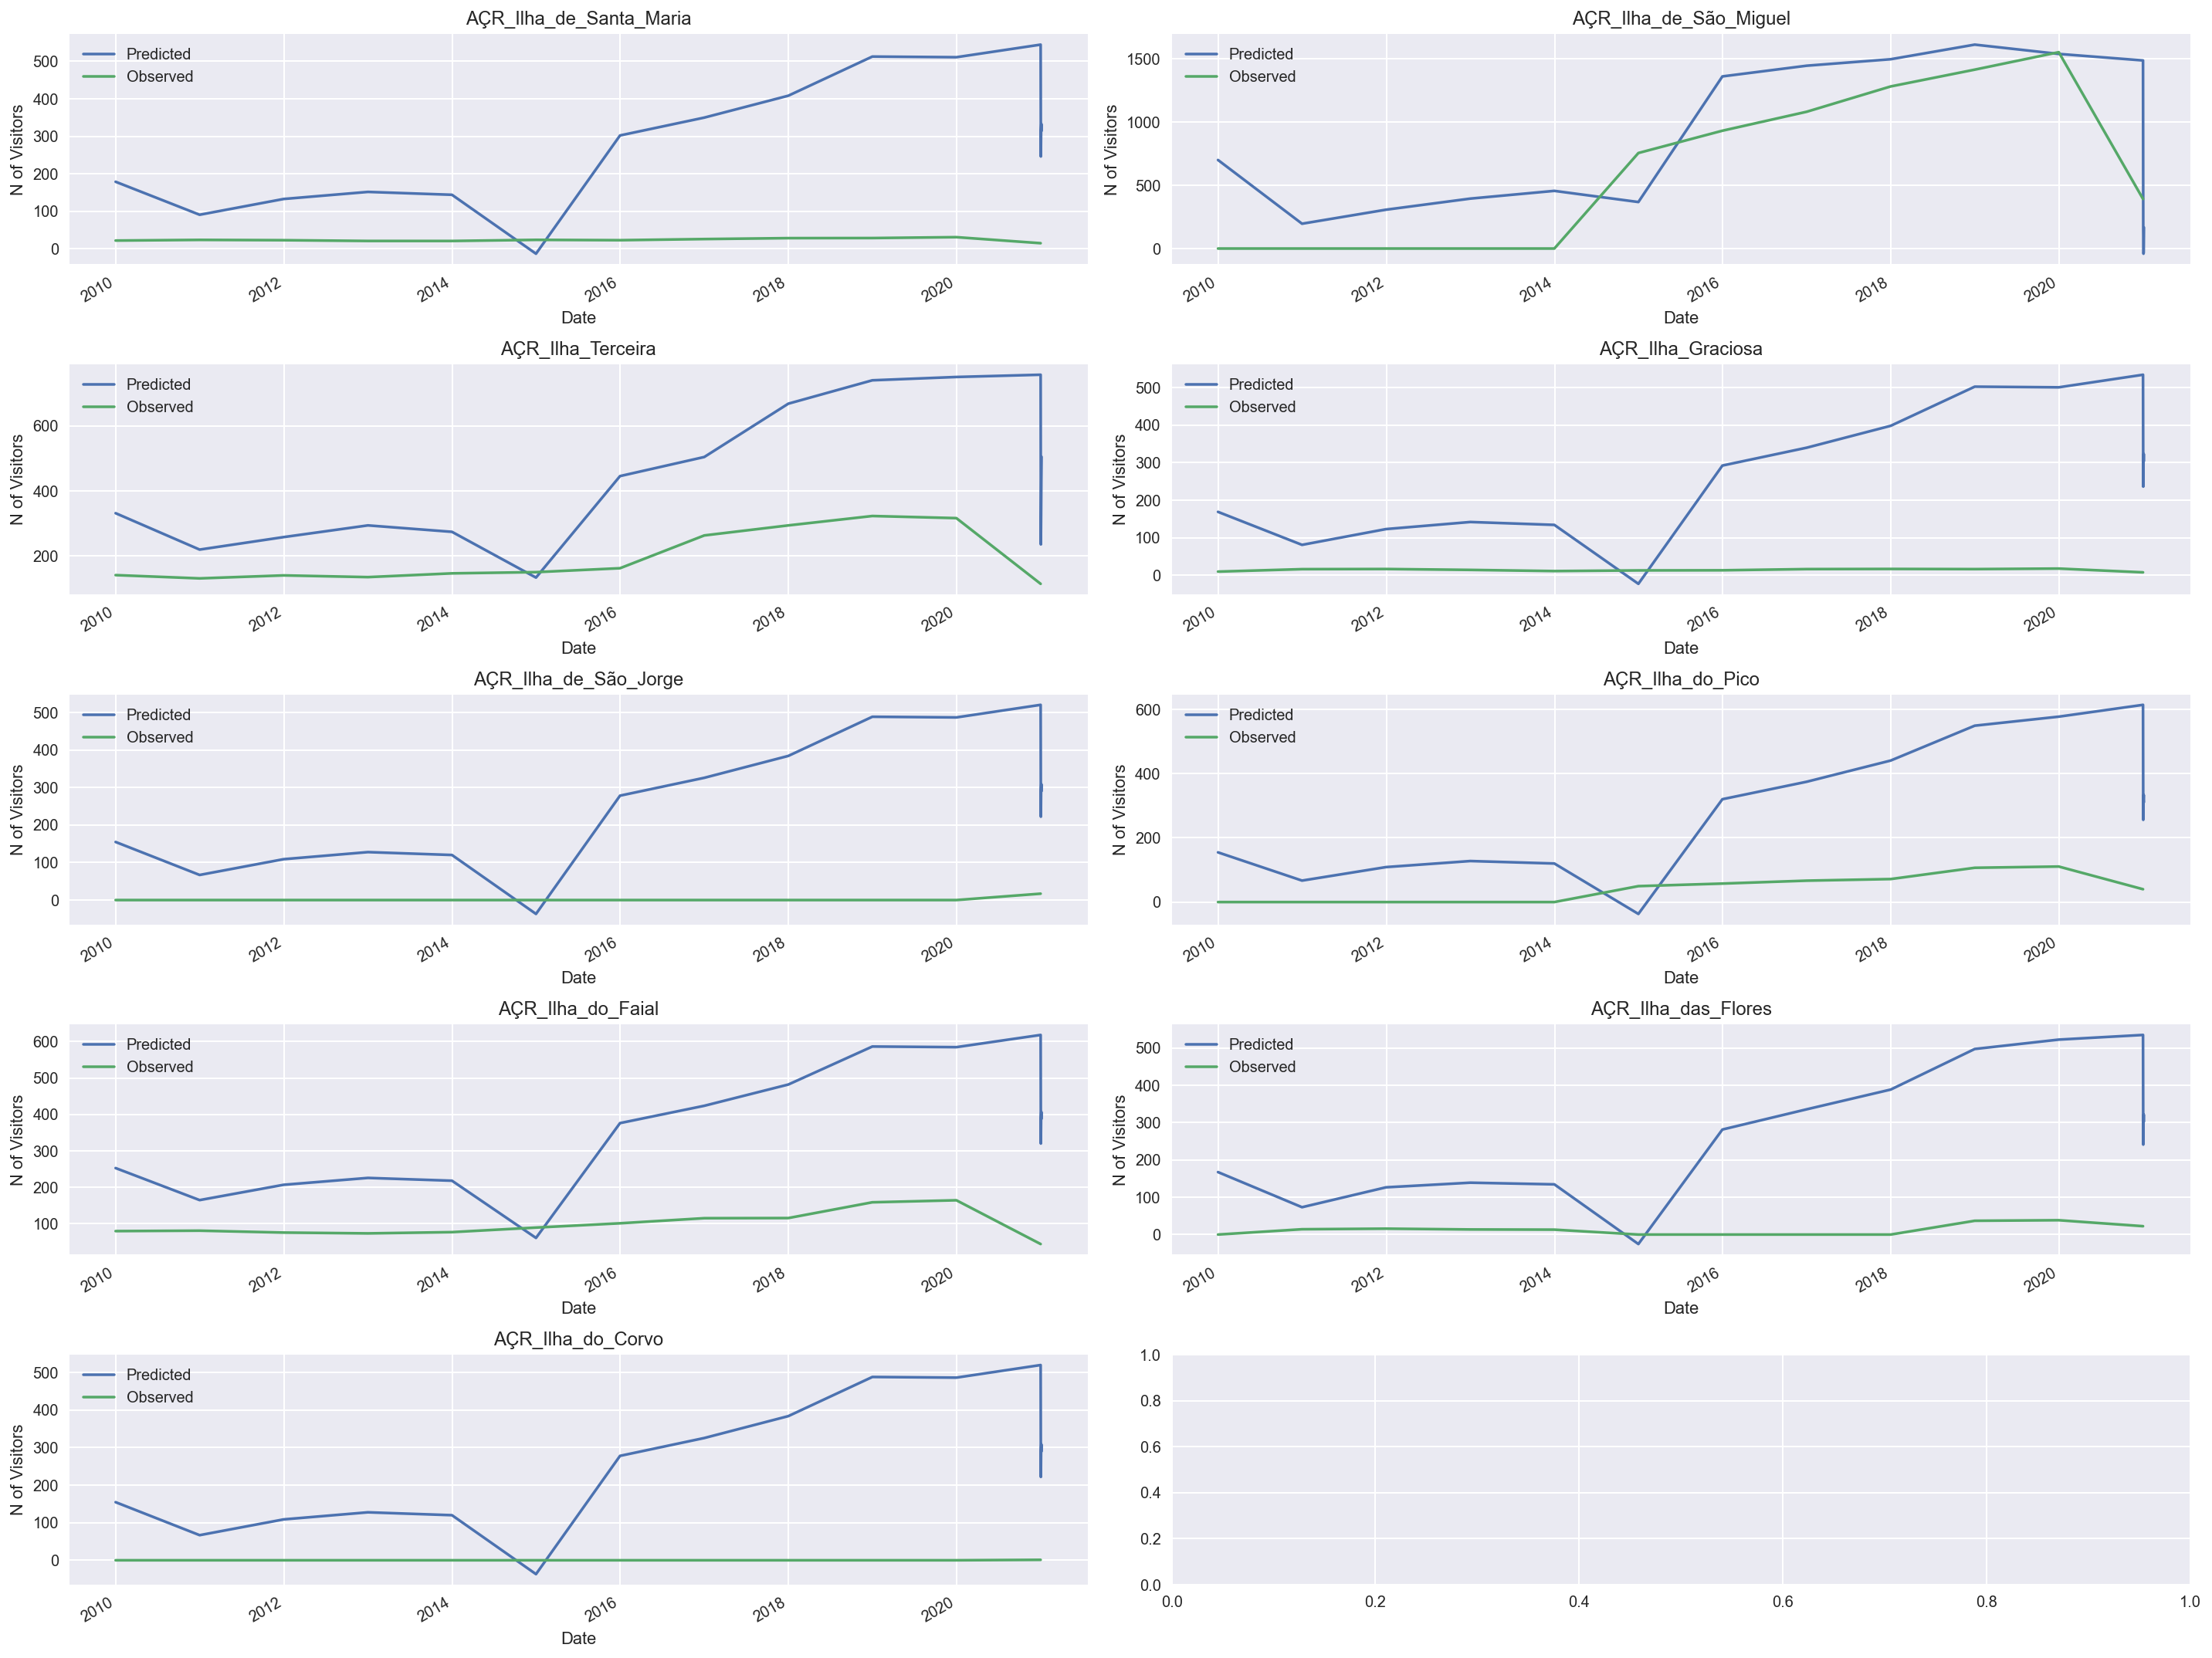

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'AÇR')], axes, predicted_autoarima)
plt.tight_layout()

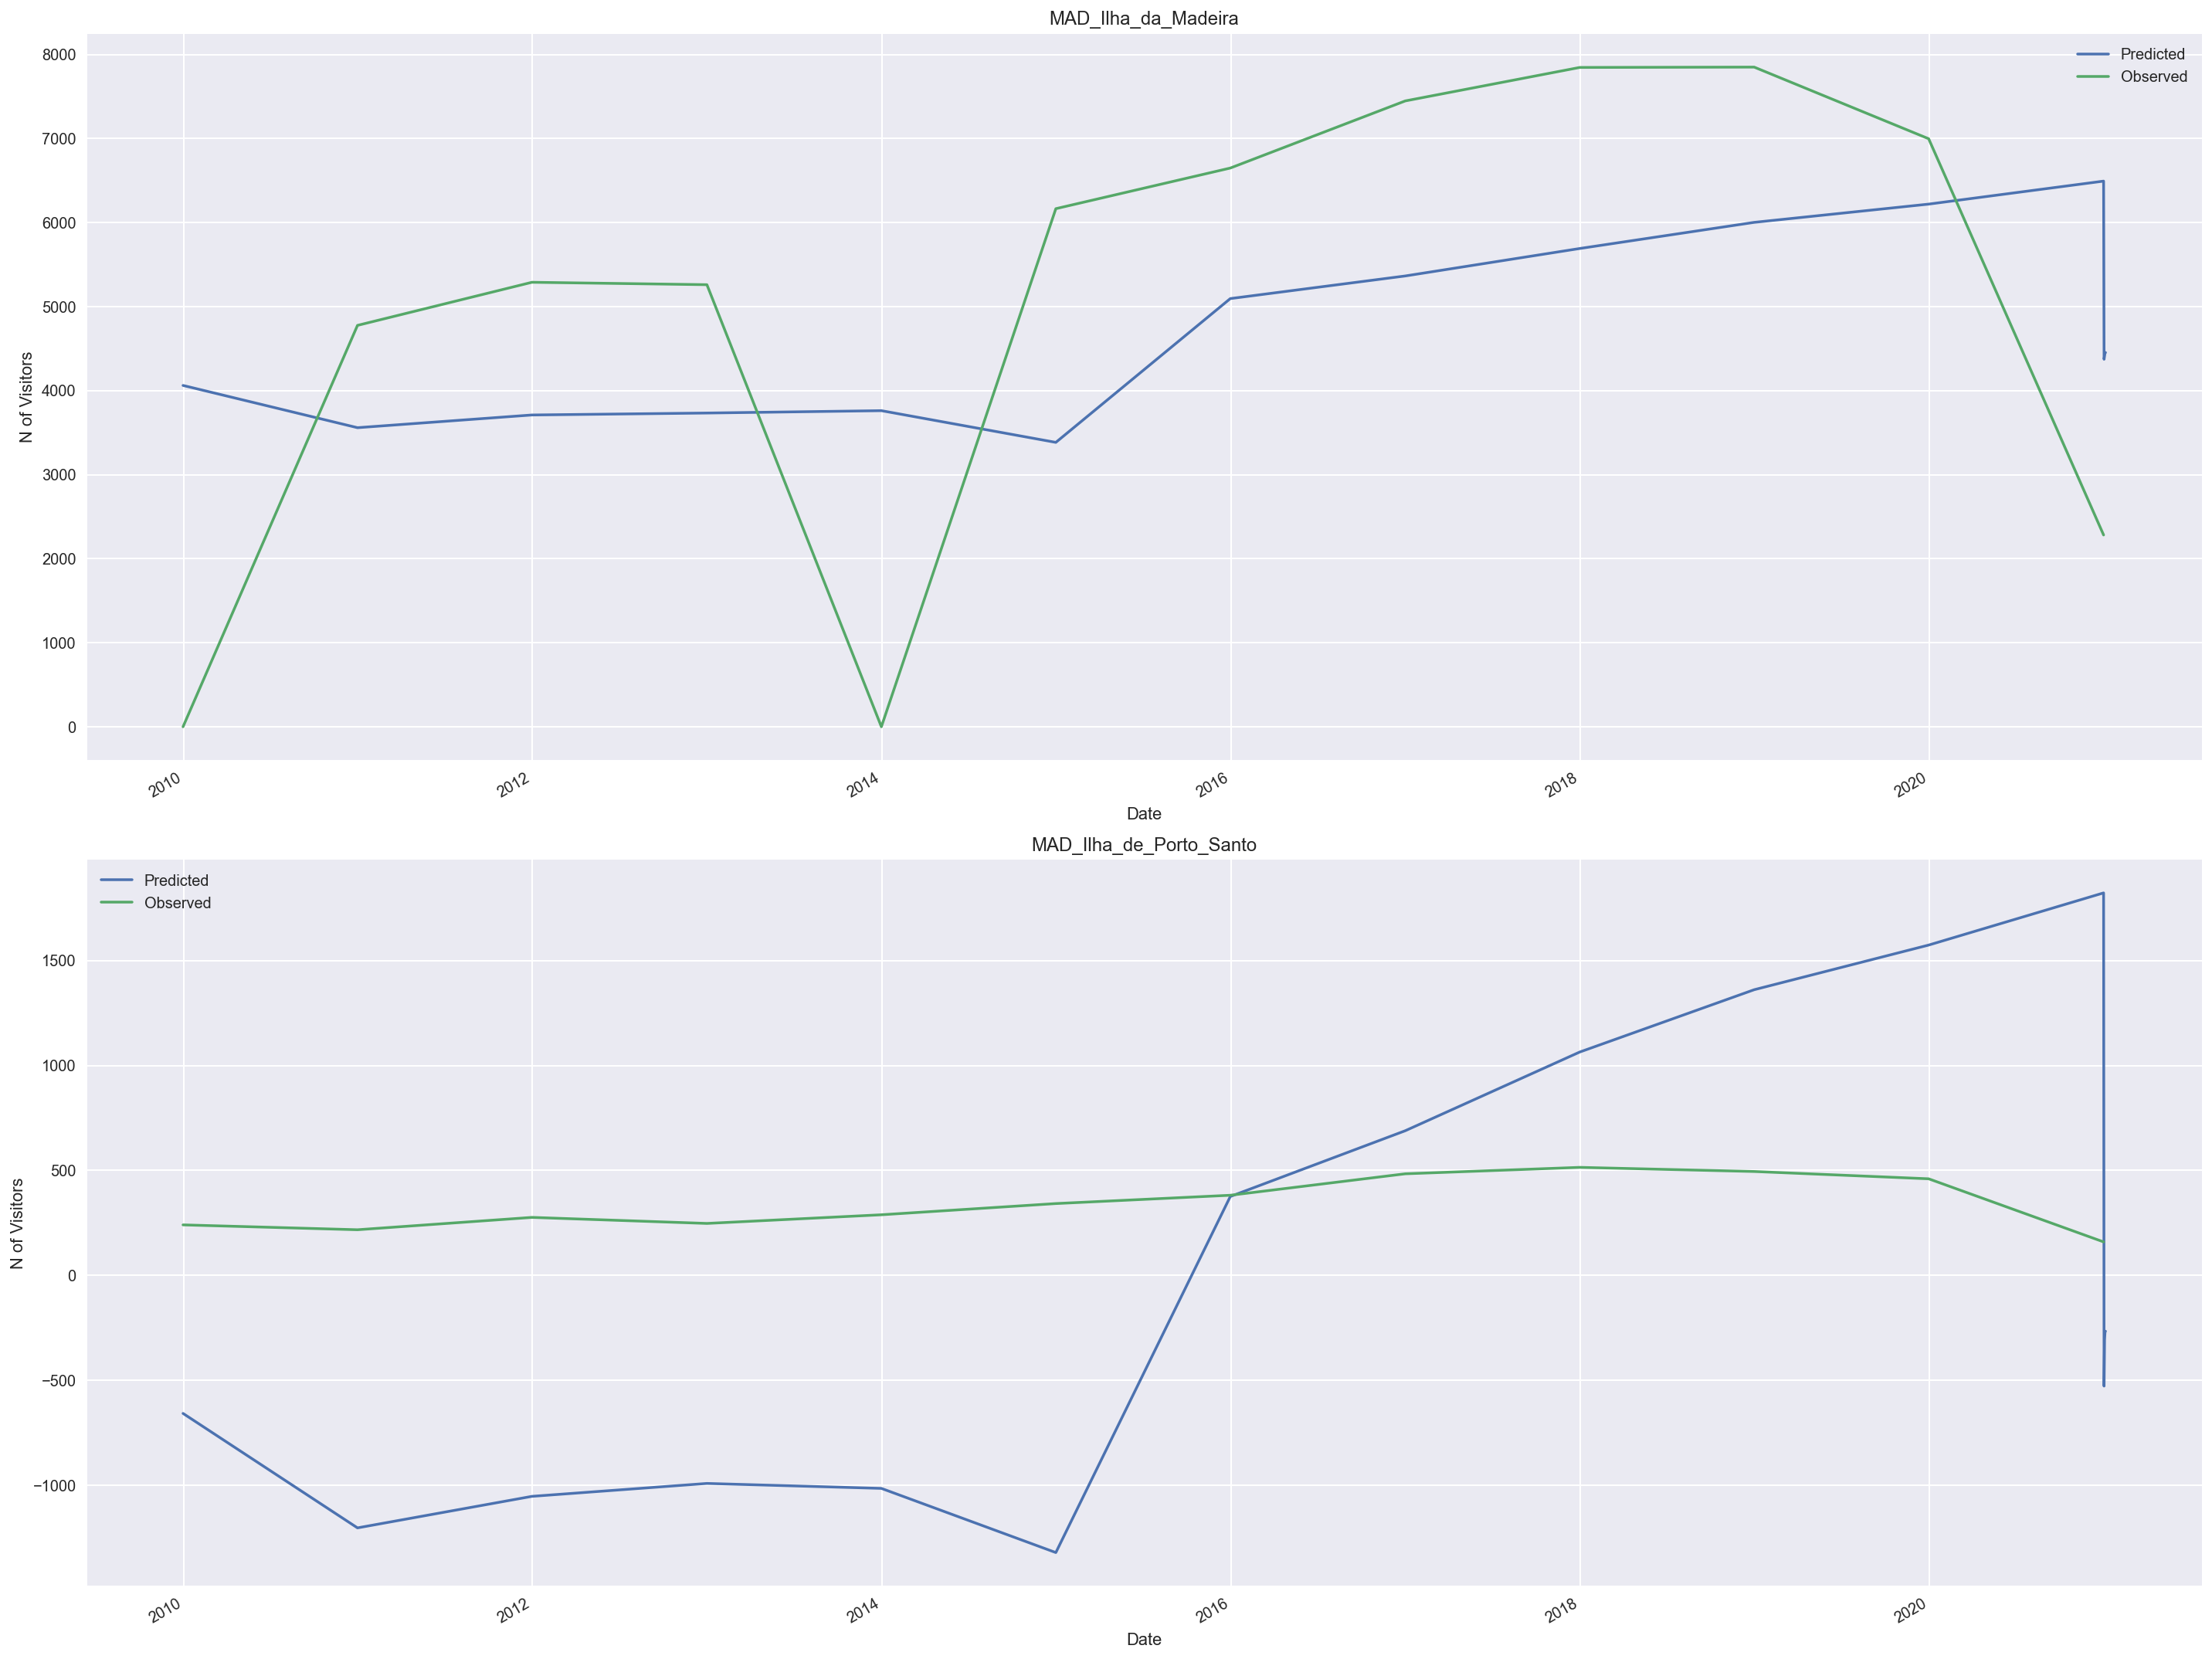

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
plot_results([x for x in nutsiii if x.startswith(f'MAD')], axes, predicted_autoarima)
plt.tight_layout()

## Prophet

In [34]:


model_bu_prophet = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
model_bu_prophet = model_bu_prophet.fit(hierarchy_data, hierarchy)
pred_bu_prophet = model_bu_prophet.predict(steps_ahead=4)



Fitting models:   0%|                                                                           | 0/42 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
Fitting models:   2%|█▌                                                                 | 1/42 [00:01<01:08,  1.66s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
Fitting models:   5%|███▏                                                               | 2/42 [00:01<00:32,  1.25it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [35]:
clf = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model = clf.fit(hierarchy_data, hierarchy)

Fitting models:   0%|                                                                           | 0/42 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
Fitting models:   2%|█▌                                                                 | 1/42 [00:00<00:06,  6.43it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
Fitting models:   5%|███▏                                                               | 2/42 [00:00<00:07,  5.52it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [36]:
predicted_prophet = model.predict(steps_ahead=8)

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 42/42 [00:38<00:00,  1.08it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000019EDD029460>
